In [1]:
!pip install torch torchvision
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 509 (delta 119), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (509/509), 9.46 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [3]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [4]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)



In [5]:
# Set random seed
set_seed(26092020)

In [6]:
train_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/dataset/refs/heads/main/train.tsv'
valid_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/dataset/refs/heads/main/valid.tsv'
test_dataset_path = 'https://raw.githubusercontent.com/MIAbidin/dataset/refs/heads/main/test.tsv'


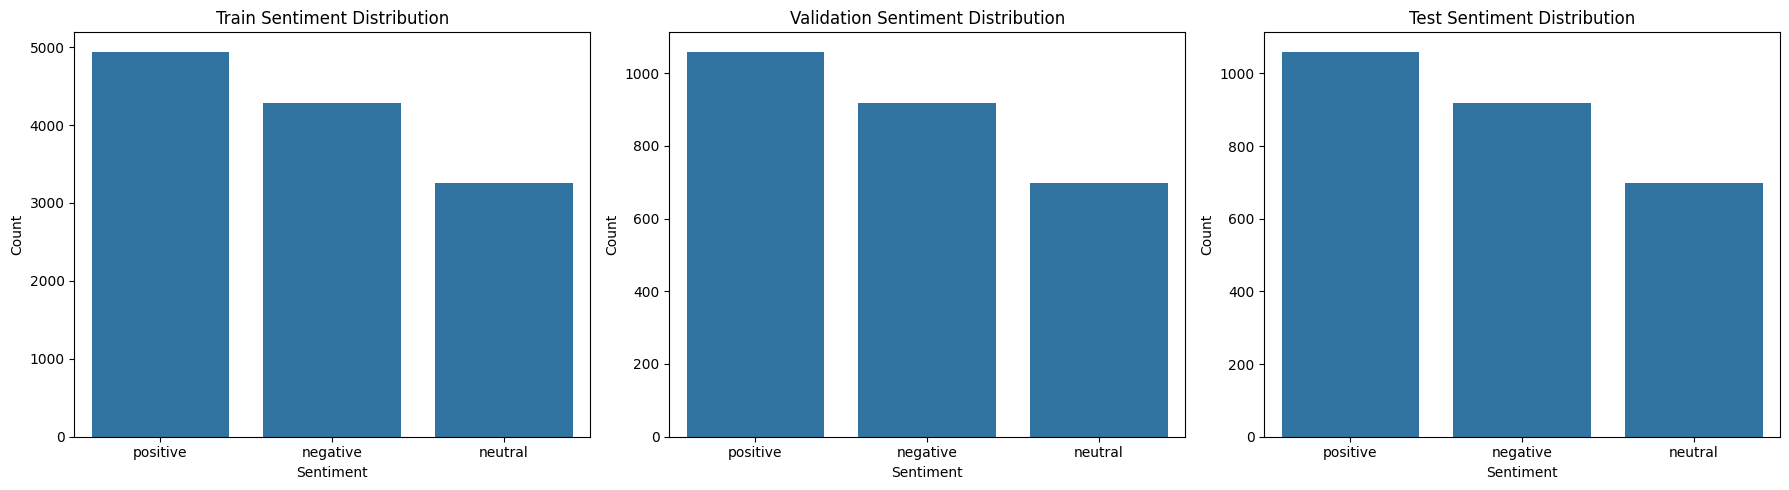

Distribusi Sentimen - Train Set:
label
positive    4943
negative    4282
neutral     3255
Name: count, dtype: int64 

Distribusi Sentimen - Validation Set:
label
positive    1059
negative     917
neutral      698
Name: count, dtype: int64 

Distribusi Sentimen - Test Set:
label
positive    1060
negative     918
neutral      697
Name: count, dtype: int64 



In [7]:
# Load your data (replace with your actual data loading)
col_names = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep='\t', header=None, names=col_names)
valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None, names=col_names)
test_df = pd.read_csv(test_dataset_path, sep='\t', header=None, names=col_names)

# Assuming the sentiment column is the second column (index 1)
train_sentiment_counts = train_df['label'].value_counts()
valid_sentiment_counts = valid_df['label'].value_counts()
test_sentiment_counts = test_df['label'].value_counts()

# Create the plot
plt.figure(figsize=(18, 5))  # Disesuaikan ukurannya untuk 3 subplot

# Train
plt.subplot(1, 3, 1)
sns.barplot(x=train_sentiment_counts.index, y=train_sentiment_counts.values)
plt.title('Train Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Validation
plt.subplot(1, 3, 2)
sns.barplot(x=valid_sentiment_counts.index, y=valid_sentiment_counts.values)
plt.title('Validation Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Test
plt.subplot(1, 3, 3)
sns.barplot(x=test_sentiment_counts.index, y=test_sentiment_counts.values)
plt.title('Test Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("Distribusi Sentimen - Train Set:")
print(train_sentiment_counts, "\n")

print("Distribusi Sentimen - Validation Set:")
print(valid_sentiment_counts, "\n")

print("Distribusi Sentimen - Test Set:")
print(test_sentiment_counts, "\n")

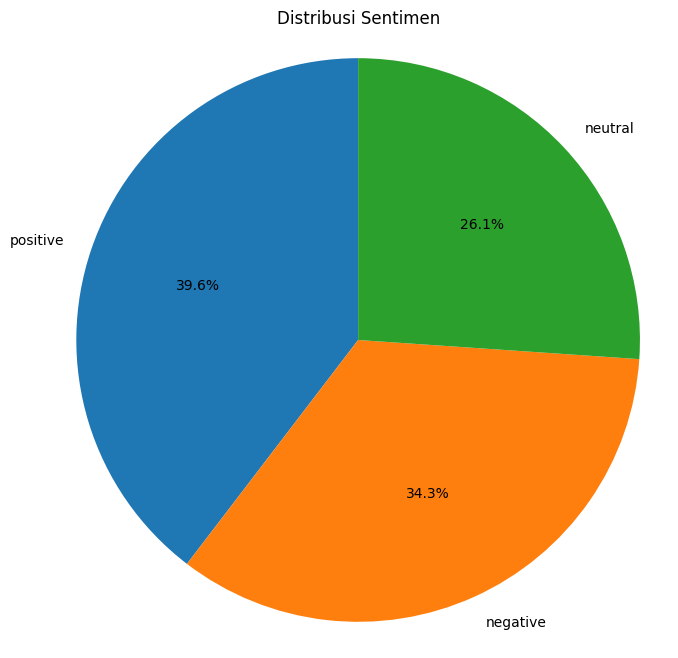

In [8]:
total_sentiment_counts = train_sentiment_counts + valid_sentiment_counts + test_sentiment_counts

plt.figure(figsize=(8, 8))
plt.pie(total_sentiment_counts, labels=total_sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Sentimen')
plt.axis('equal')
plt.show()


# IndoRoBERTa

In [ ]:
tokenizer1 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config1 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config1.num_labels = DocumentSentimentDataset.NUM_LABELS
model1 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config1)


tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model1

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
count_param(model1)

124647939

In [ ]:
indoroberta_param_count = count_param(model1, trainable=True)

In [ ]:
train_dataset1 = DocumentSentimentDataset(train_dataset_path, tokenizer1, lowercase=True)
valid_dataset1 = DocumentSentimentDataset(valid_dataset_path, tokenizer1, lowercase=True)
test_dataset1 = DocumentSentimentDataset(test_dataset_path, tokenizer1, lowercase=True)

train_loader1 = DocumentSentimentDataLoader(dataset=train_dataset1, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader1 = DocumentSentimentDataLoader(dataset=valid_dataset1, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader1 = DocumentSentimentDataLoader(dataset=test_dataset1, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : negative (35.523%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (34.816%)


In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=1e-5)
model = model1.cuda()


In [ ]:
# Metrik penyimpanan
train_losses1, train_accuracies1 = [], []
valid_losses1, valid_accuracies1 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader1, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader1)
    train_losses1.append(avg_train_loss)
    train_accuracies1.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader1, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader1)
    valid_losses1.append(avg_valid_loss)
    valid_accuracies1.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta1_train_time = end_time - start_time
indoroberta1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta1 - Waktu training: {indoroberta1_train_time:.2f} detik | Peak memory: {indoroberta1_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 90/90 [00:05<00:00, 16.17it/s]


Epoch 1/15 | Train Loss: 0.7398 | Train Acc: 0.6773 | Valid Loss: 0.5731 | Valid Acc: 0.7701

Epoch 2/15


Validating Epoch 2: 100%|██████████| 90/90 [00:05<00:00, 15.90it/s]


Epoch 2/15 | Train Loss: 0.4990 | Train Acc: 0.8094 | Valid Loss: 0.4790 | Valid Acc: 0.8181

Epoch 3/15


Validating Epoch 3: 100%|██████████| 90/90 [00:05<00:00, 15.83it/s]


Epoch 3/15 | Train Loss: 0.3670 | Train Acc: 0.8648 | Valid Loss: 0.4591 | Valid Acc: 0.8360

Epoch 4/15


Validating Epoch 4: 100%|██████████| 90/90 [00:05<00:00, 15.88it/s]


Epoch 4/15 | Train Loss: 0.2778 | Train Acc: 0.9008 | Valid Loss: 0.4850 | Valid Acc: 0.8461
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 90/90 [00:05<00:00, 15.66it/s]


Epoch 5/15 | Train Loss: 0.2092 | Train Acc: 0.9268 | Valid Loss: 0.4583 | Valid Acc: 0.8598

Epoch 6/15


Validating Epoch 6: 100%|██████████| 90/90 [00:05<00:00, 15.47it/s]


Epoch 6/15 | Train Loss: 0.1548 | Train Acc: 0.9451 | Valid Loss: 0.5084 | Valid Acc: 0.8521
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 7/15


Validating Epoch 7: 100%|██████████| 90/90 [00:05<00:00, 15.40it/s]


Epoch 7/15 | Train Loss: 0.1235 | Train Acc: 0.9569 | Valid Loss: 0.5284 | Valid Acc: 0.8630
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 90/90 [00:05<00:00, 15.54it/s]

Epoch 8/15 | Train Loss: 0.0946 | Train Acc: 0.9667 | Valid Loss: 0.5486 | Valid Acc: 0.8566
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 8. Training dihentikan.

IndoRoberta1 - Waktu training: 628.90 detik | Peak memory: 6582.12 MB


In [ ]:
!nvidia-smi

Sun Jun 22 03:00:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |    7130MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

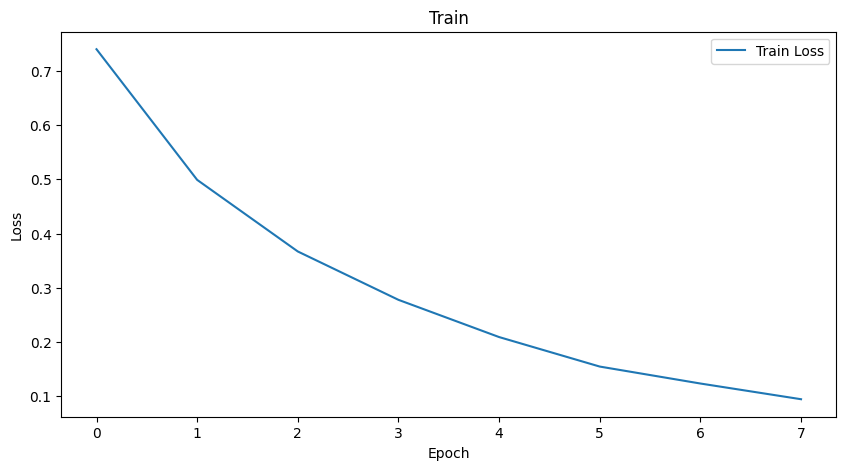

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses1, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

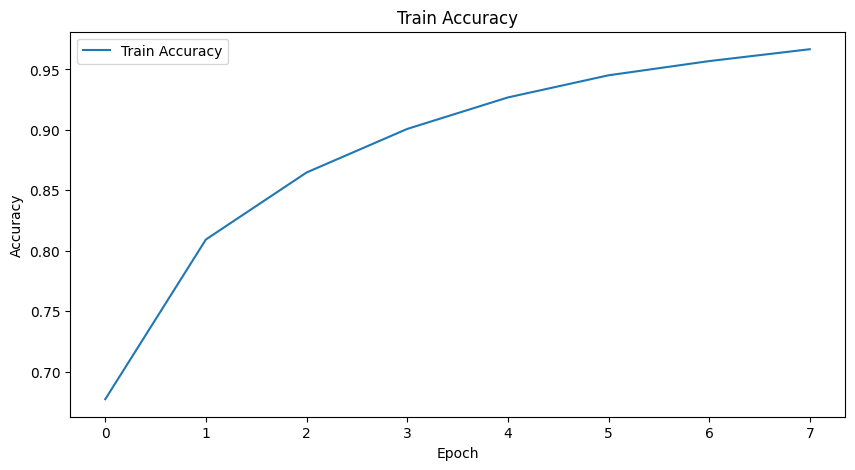

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies1, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
import os

output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result4/IndoRoBERTa_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader1, leave=True, total=len(test_loader1))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model1.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 112/112 [00:06<00:00, 16.03it/s]



Test Metrics: ACC:0.86 F1:0.86 REC:0.85 PRE:0.86


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses1)+1)),
    'train_loss': train_losses1,
    'train_accuracy': train_accuracies1,
    'valid_loss': valid_losses1,
    'valid_accuracy': valid_accuracies1
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta1_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta1_train_time],
    'peak_memory_MB': [indoroberta1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta1_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta1_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta1_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      1230
     neutral       0.86      0.82      0.84       968
    positive       0.86      0.89      0.87      1368

    accuracy                           0.86      3566
   macro avg       0.86      0.85      0.86      3566
weighted avg       0.86      0.86      0.86      3566



In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta1_confusion_matrix.csv'))

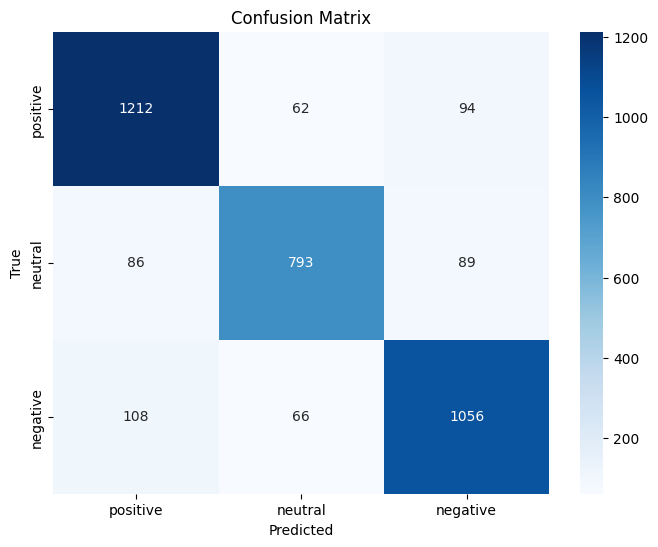

In [ ]:
# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (90.706%)


In [ ]:
text = 'sty stay'
subwords = tokenizer1.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model1.device)

logits = model1(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : neutral (99.744%)


# IndoRoBERTa

In [ ]:
tokenizer2 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config2 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config2.num_labels = DocumentSentimentDataset.NUM_LABELS
model2 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model2

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
train_dataset2 = DocumentSentimentDataset(train_dataset_path, tokenizer2, lowercase=True)
valid_dataset2 = DocumentSentimentDataset(valid_dataset_path, tokenizer2, lowercase=True)
test_dataset2 = DocumentSentimentDataset(test_dataset_path, tokenizer2, lowercase=True)

train_loader2 = DocumentSentimentDataLoader(dataset=train_dataset2, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader2 = DocumentSentimentDataLoader(dataset=valid_dataset2, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader2 = DocumentSentimentDataLoader(dataset=test_dataset2, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : negative (35.466%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (41.201%)


In [ ]:
optimizer = optim.Adam(model2.parameters(), lr=3e-6)
model = model2.cuda()


In [ ]:
# Metrik penyimpanan
train_losses2, train_accuracies2 = [], []
valid_losses2, valid_accuracies2 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader2, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader2)
    train_losses2.append(avg_train_loss)
    train_accuracies2.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader2, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader2)
    valid_losses2.append(avg_valid_loss)
    valid_accuracies2.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta2_train_time = end_time - start_time
indoroberta2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta2 - Waktu training: {indoroberta2_train_time:.2f} detik | Peak memory: {indoroberta2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 90/90 [00:05<00:00, 15.97it/s]


Epoch 1/15 | Train Loss: 0.8917 | Train Acc: 0.5761 | Valid Loss: 0.6892 | Valid Acc: 0.7091

Epoch 2/15


Validating Epoch 2: 100%|██████████| 90/90 [00:05<00:00, 15.68it/s]


Epoch 2/15 | Train Loss: 0.6647 | Train Acc: 0.7216 | Valid Loss: 0.6031 | Valid Acc: 0.7532

Epoch 3/15


Validating Epoch 3: 100%|██████████| 90/90 [00:05<00:00, 15.71it/s]


Epoch 3/15 | Train Loss: 0.5745 | Train Acc: 0.7678 | Valid Loss: 0.5695 | Valid Acc: 0.7767

Epoch 4/15


Validating Epoch 4: 100%|██████████| 90/90 [00:05<00:00, 15.84it/s]


Epoch 4/15 | Train Loss: 0.5075 | Train Acc: 0.8037 | Valid Loss: 0.5195 | Valid Acc: 0.7978

Epoch 5/15


Validating Epoch 5: 100%|██████████| 90/90 [00:05<00:00, 15.88it/s]


Epoch 5/15 | Train Loss: 0.4531 | Train Acc: 0.8288 | Valid Loss: 0.4877 | Valid Acc: 0.8135

Epoch 6/15


Validating Epoch 6: 100%|██████████| 90/90 [00:05<00:00, 15.90it/s]


Epoch 6/15 | Train Loss: 0.4051 | Train Acc: 0.8497 | Valid Loss: 0.4780 | Valid Acc: 0.8247

Epoch 7/15


Validating Epoch 7: 100%|██████████| 90/90 [00:05<00:00, 15.94it/s]


Epoch 7/15 | Train Loss: 0.3646 | Train Acc: 0.8657 | Valid Loss: 0.4748 | Valid Acc: 0.8261

Epoch 8/15


Validating Epoch 8: 100%|██████████| 90/90 [00:05<00:00, 15.55it/s]


Epoch 8/15 | Train Loss: 0.3262 | Train Acc: 0.8826 | Valid Loss: 0.4696 | Valid Acc: 0.8437

Epoch 9/15


Validating Epoch 9: 100%|██████████| 90/90 [00:05<00:00, 15.58it/s]


Epoch 9/15 | Train Loss: 0.2912 | Train Acc: 0.8958 | Valid Loss: 0.4596 | Valid Acc: 0.8454

Epoch 10/15


Validating Epoch 10: 100%|██████████| 90/90 [00:05<00:00, 15.57it/s]


Epoch 10/15 | Train Loss: 0.2580 | Train Acc: 0.9080 | Valid Loss: 0.4773 | Valid Acc: 0.8472
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 11/15


Validating Epoch 11: 100%|██████████| 90/90 [00:05<00:00, 15.87it/s]


Epoch 11/15 | Train Loss: 0.2357 | Train Acc: 0.9144 | Valid Loss: 0.4880 | Valid Acc: 0.8472
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 12/15


Validating Epoch 12: 100%|██████████| 90/90 [00:05<00:00, 15.79it/s]


Epoch 12/15 | Train Loss: 0.2125 | Train Acc: 0.9244 | Valid Loss: 0.4915 | Valid Acc: 0.8521
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 12. Training dihentikan.

IndoRoberta2 - Waktu training: 935.94 detik | Peak memory: 7559.33 MB


In [ ]:
!nvidia-smi

Sun Jun 22 03:17:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |    8146MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

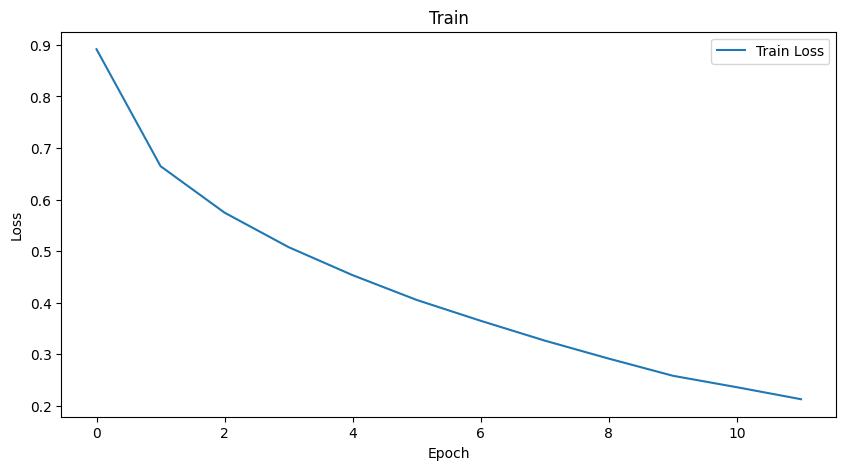

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses2, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

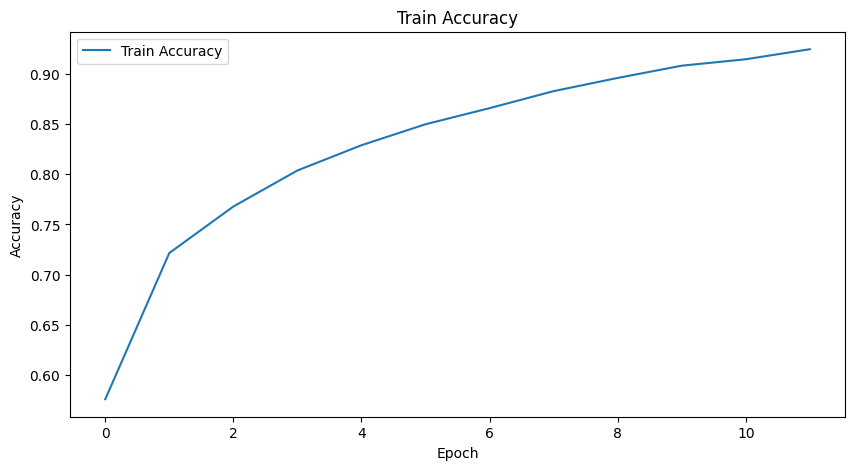

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies2, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result4/IndoRoBERTa_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader2, leave=True, total=len(test_loader2))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model2.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 112/112 [00:07<00:00, 15.75it/s]



Test Metrics: ACC:0.84 F1:0.84 REC:0.83 PRE:0.84


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses2)+1)),
    'train_loss': train_losses2,
    'train_accuracy': train_accuracies2,
    'valid_loss': valid_losses2,
    'valid_accuracy': valid_accuracies2
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta2_train_time],
    'peak_memory_MB': [indoroberta2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83      1230
     neutral       0.85      0.80      0.82       968
    positive       0.83      0.88      0.85      1368

    accuracy                           0.84      3566
   macro avg       0.84      0.83      0.84      3566
weighted avg       0.84      0.84      0.84      3566



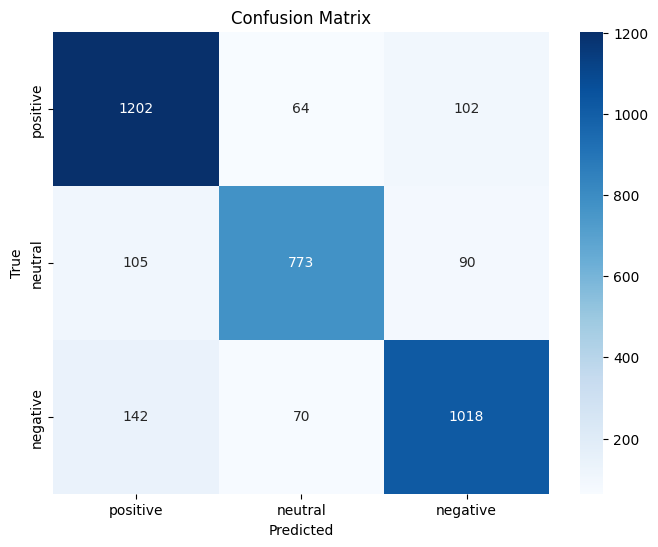

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta_confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (96.019%)


In [ ]:
text = 'sty stay'
subwords = tokenizer2.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model2.device)

logits = model2(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : neutral (99.582%)


# IndoRoBERTa

In [ ]:
tokenizer3 = RobertaTokenizer.from_pretrained('flax-community/indonesian-roberta-base')
config3 = RobertaConfig.from_pretrained('flax-community/indonesian-roberta-base')
config3.num_labels = DocumentSentimentDataset.NUM_LABELS
model3 = RobertaForSequenceClassification.from_pretrained('flax-community/indonesian-roberta-base', config=config3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/indonesian-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model3

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
train_dataset3 = DocumentSentimentDataset(train_dataset_path, tokenizer3, lowercase=True)
valid_dataset3 = DocumentSentimentDataset(valid_dataset_path, tokenizer3, lowercase=True)
test_dataset3 = DocumentSentimentDataset(test_dataset_path, tokenizer3, lowercase=True)

train_loader3 = DocumentSentimentDataLoader(dataset=train_dataset3, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader3 = DocumentSentimentDataLoader(dataset=valid_dataset3, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader3 = DocumentSentimentDataLoader(dataset=test_dataset3, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (43.185%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (42.031%)


In [ ]:
optimizer = optim.Adam(model3.parameters(), lr=5e-5)
model = model3.cuda()


In [ ]:
# Metrik penyimpanan
train_losses3, train_accuracies3 = [], []
valid_losses3, valid_accuracies3 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader3, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader3)
    train_losses3.append(avg_train_loss)
    train_accuracies3.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader3, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader3)
    valid_losses3.append(avg_valid_loss)
    valid_accuracies3.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indoroberta3_train_time = end_time - start_time
indoroberta3_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoRoberta3 - Waktu training: {indoroberta3_train_time:.2f} detik | Peak memory: {indoroberta3_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 84/84 [00:05<00:00, 15.46it/s]


Epoch 1/15 | Train Loss: 0.6128 | Train Acc: 0.7477 | Valid Loss: 0.4694 | Valid Acc: 0.8250

Epoch 2/15


Validating Epoch 2: 100%|██████████| 84/84 [00:05<00:00, 14.54it/s]


Epoch 2/15 | Train Loss: 0.3440 | Train Acc: 0.8783 | Valid Loss: 0.4105 | Valid Acc: 0.8594

Epoch 3/15


Validating Epoch 3: 100%|██████████| 84/84 [00:05<00:00, 14.18it/s]


Epoch 3/15 | Train Loss: 0.2206 | Train Acc: 0.9252 | Valid Loss: 0.4421 | Valid Acc: 0.8747
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 84/84 [00:05<00:00, 14.42it/s]


Epoch 4/15 | Train Loss: 0.1536 | Train Acc: 0.9488 | Valid Loss: 0.4153 | Valid Acc: 0.8706
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 84/84 [00:05<00:00, 14.32it/s]

Epoch 5/15 | Train Loss: 0.1183 | Train Acc: 0.9596 | Valid Loss: 0.4879 | Valid Acc: 0.8770
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

IndoRoberta3 - Waktu training: 412.91 detik | Peak memory: 4240.32 MB


In [ ]:
!nvidia-smi

Tue Jun 24 02:17:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |    5476MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

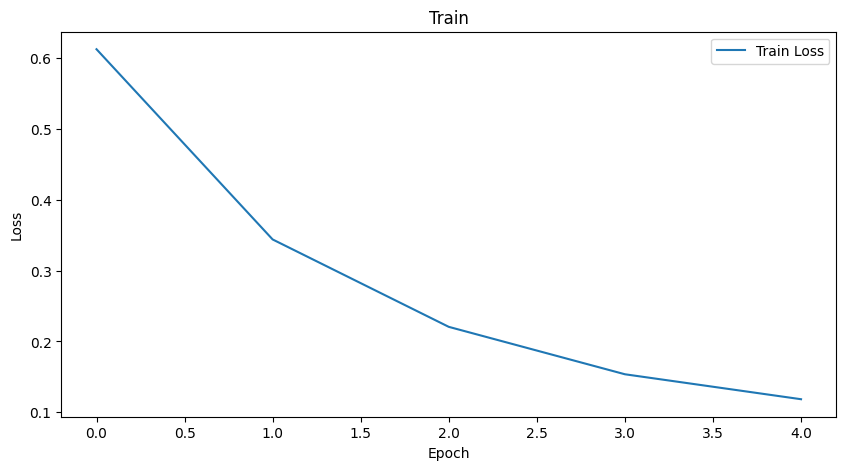

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses3, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

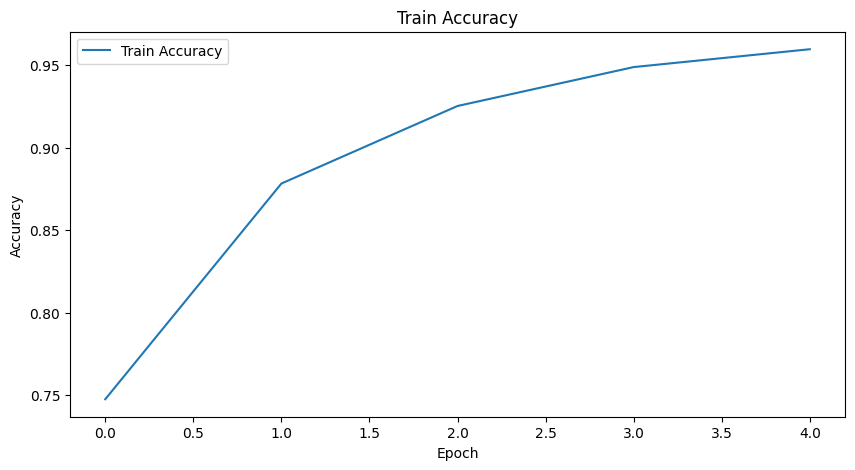

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies3, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/REVISI/result/IndoRoBERTa_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader3, leave=True, total=len(test_loader3))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model3.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 84/84 [00:06<00:00, 12.79it/s]



Test Metrics: ACC:0.85 F1:0.85 REC:0.84 PRE:0.86


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses3)+1)),
    'train_loss': train_losses3,
    'train_accuracy': train_accuracies3,
    'valid_loss': valid_losses3,
    'valid_accuracy': valid_accuracies3
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'indoroberta_metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoRoBERTa'],
    'train_time_seconds': [indoroberta3_train_time],
    'peak_memory_MB': [indoroberta3_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'indoroberta_time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoRoBERTa',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'indoroberta_test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'indoroberta_classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       918
     neutral       0.90      0.75      0.82       697
    positive       0.84      0.92      0.88      1060

    accuracy                           0.85      2675
   macro avg       0.86      0.84      0.85      2675
weighted avg       0.86      0.85      0.85      2675



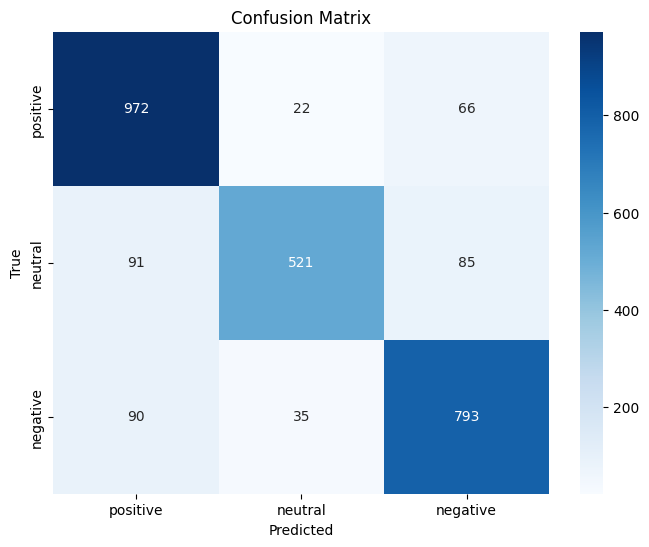

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'indoroberta_confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (98.214%)


In [ ]:
text = 'sty stay'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.718%)


In [ ]:
model3.save_pretrained("model_roberta_sentimen")
tokenizer3.save_pretrained("model_roberta_sentimen")

('model_roberta_sentimen/tokenizer_config.json',
 'model_roberta_sentimen/special_tokens_map.json',
 'model_roberta_sentimen/vocab.json',
 'model_roberta_sentimen/merges.txt',
 'model_roberta_sentimen/added_tokens.json')

In [ ]:
!zip -r /content/model_roberta_sentimen.zip /content/model_roberta_sentimen
from google.colab import files
files.download("/content/model_roberta_sentimen.zip")


  adding: content/model_roberta_sentimen/ (stored 0%)
  adding: content/model_roberta_sentimen/merges.txt (deflated 54%)
  adding: content/model_roberta_sentimen/vocab.json (deflated 68%)
  adding: content/model_roberta_sentimen/tokenizer_config.json (deflated 76%)
  adding: content/model_roberta_sentimen/special_tokens_map.json (deflated 85%)
  adding: content/model_roberta_sentimen/model.safetensors (deflated 7%)
  adding: content/model_roberta_sentimen/config.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# IndoBERT Large

In [ ]:
tokenizer4 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config4 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config4.num_labels = DocumentSentimentDataset.NUM_LABELS
model4 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model4

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
count_param(model4)

335144963

In [ ]:
indobertLarge_param_count = count_param(model4, trainable=True)

In [ ]:
train_dataset4 = DocumentSentimentDataset(train_dataset_path, tokenizer4, lowercase=True)
valid_dataset4 = DocumentSentimentDataset(valid_dataset_path, tokenizer4, lowercase=True)
test_dataset4 = DocumentSentimentDataset(test_dataset_path, tokenizer4, lowercase=True)

train_loader4 = DocumentSentimentDataLoader(dataset=train_dataset4, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader4 = DocumentSentimentDataLoader(dataset=valid_dataset4, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader4 = DocumentSentimentDataLoader(dataset=test_dataset4, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (39.644%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (37.579%)


In [ ]:
optimizer = optim.Adam(model4.parameters(), lr=1e-5)
model = model4.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses4, train_accuracies4 = [], []
valid_losses4, valid_accuracies4 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader4, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader4)
    train_losses4.append(avg_train_loss)
    train_accuracies4.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader4, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader4)
    valid_losses4.append(avg_valid_loss)
    valid_accuracies4.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert1_train_time = end_time - start_time
indobert1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT1 - Waktu training: {indobert1_train_time:.2f} detik | Peak memory: {indobert1_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 90/90 [00:18<00:00,  4.92it/s]


Epoch 1/15 | Train Loss: 0.6622 | Train Acc: 0.7219 | Valid Loss: 0.4984 | Valid Acc: 0.8083

Epoch 2/15


Validating Epoch 2: 100%|██████████| 90/90 [00:18<00:00,  4.94it/s]


Epoch 2/15 | Train Loss: 0.3721 | Train Acc: 0.8612 | Valid Loss: 0.3955 | Valid Acc: 0.8584

Epoch 3/15


Validating Epoch 3: 100%|██████████| 90/90 [00:18<00:00,  4.94it/s]


Epoch 3/15 | Train Loss: 0.2062 | Train Acc: 0.9289 | Valid Loss: 0.3938 | Valid Acc: 0.8682

Epoch 4/15


Validating Epoch 4: 100%|██████████| 90/90 [00:18<00:00,  4.93it/s]


Epoch 4/15 | Train Loss: 0.1091 | Train Acc: 0.9636 | Valid Loss: 0.4613 | Valid Acc: 0.8665
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 90/90 [00:18<00:00,  4.96it/s]


Epoch 5/15 | Train Loss: 0.0676 | Train Acc: 0.9779 | Valid Loss: 0.5234 | Valid Acc: 0.8630
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 6/15


Validating Epoch 6: 100%|██████████| 90/90 [00:18<00:00,  4.98it/s]

Epoch 6/15 | Train Loss: 0.0459 | Train Acc: 0.9845 | Valid Loss: 0.5549 | Valid Acc: 0.8658
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 6. Training dihentikan.

IndoBERT1 - Waktu training: 1434.79 detik | Peak memory: 11227.44 MB


In [ ]:
!nvidia-smi

Sun Jun 22 03:59:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |   14250MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

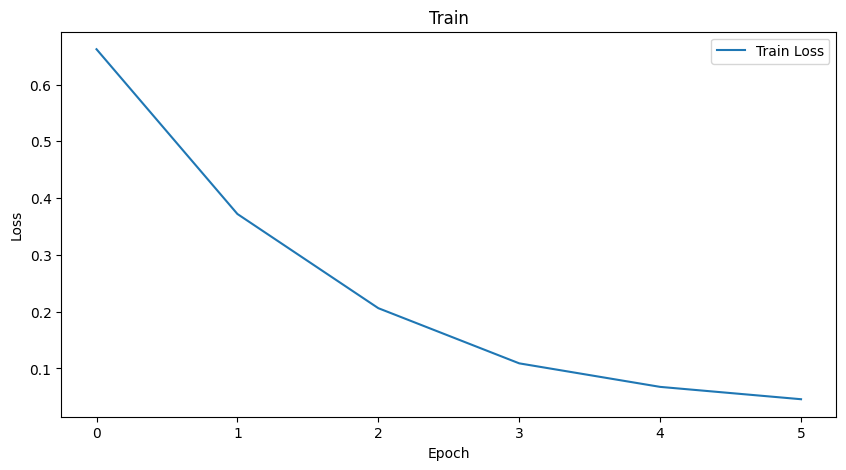

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses4, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

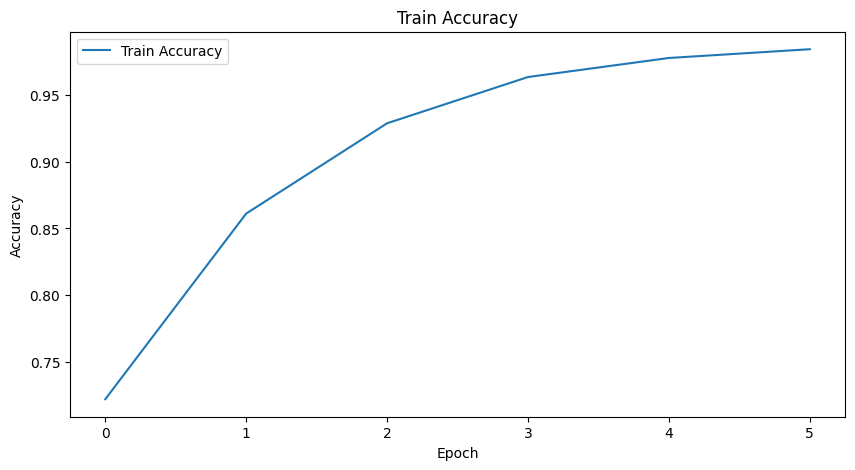

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies4, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result4/IndoBERT_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader4, leave=True, total=len(test_loader4))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model4.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 112/112 [00:21<00:00,  5.26it/s]


Test Metrics: ACC:0.87 F1:0.87 REC:0.87 PRE:0.87


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses4)+1)),
    'train_loss': train_losses4,
    'train_accuracy': train_accuracies4,
    'valid_loss': valid_losses4,
    'valid_accuracy': valid_accuracies4
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert1_train_time],
    'peak_memory_MB': [indobert1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      1230
     neutral       0.89      0.83      0.86       968
    positive       0.90      0.87      0.89      1368

    accuracy                           0.87      3566
   macro avg       0.87      0.87      0.87      3566
weighted avg       0.87      0.87      0.87      3566



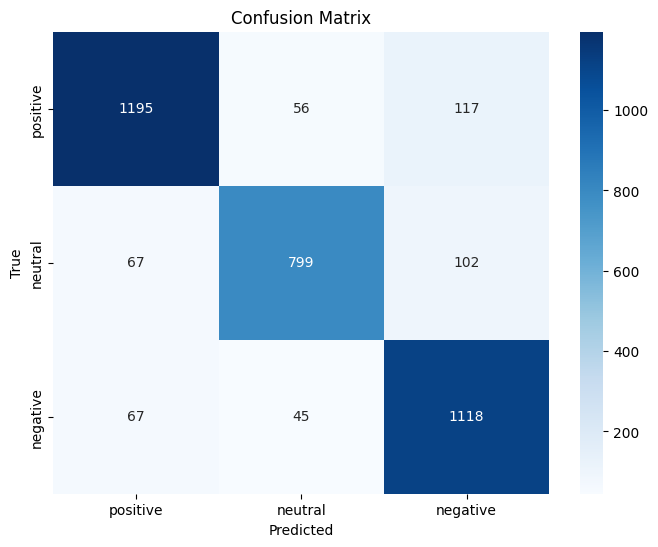

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (73.941%)


In [ ]:
text = 'sty stay'
subwords = tokenizer4.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model4.device)

logits = model4(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : neutral (99.914%)


# IndoBERT Large

In [ ]:
tokenizer5 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config5 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config5.num_labels = DocumentSentimentDataset.NUM_LABELS
model5 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config5)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model5

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
train_dataset5 = DocumentSentimentDataset(train_dataset_path, tokenizer5, lowercase=True)
valid_dataset5 = DocumentSentimentDataset(valid_dataset_path, tokenizer5, lowercase=True)
test_dataset5 = DocumentSentimentDataset(test_dataset_path, tokenizer5, lowercase=True)

train_loader5 = DocumentSentimentDataLoader(dataset=train_dataset5, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader5 = DocumentSentimentDataLoader(dataset=valid_dataset5, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader5 = DocumentSentimentDataLoader(dataset=test_dataset5, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (39.644%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (37.579%)


In [ ]:
optimizer = optim.Adam(model5.parameters(), lr=3e-6)
model = model5.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses5, train_accuracies5 = [], []
valid_losses5, valid_accuracies5 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader5, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader5)
    train_losses5.append(avg_train_loss)
    train_accuracies5.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader5, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader5)
    valid_losses5.append(avg_valid_loss)
    valid_accuracies5.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert2_train_time = end_time - start_time
indobert2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT2 - Waktu training: {indobert2_train_time:.2f} detik | Peak memory: {indobert2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 84/84 [00:16<00:00,  5.00it/s]


Epoch 1/15 | Train Loss: 0.8505 | Train Acc: 0.6157 | Valid Loss: 0.6811 | Valid Acc: 0.7105

Epoch 2/15


Validating Epoch 2: 100%|██████████| 84/84 [00:16<00:00,  4.98it/s]


Epoch 2/15 | Train Loss: 0.6315 | Train Acc: 0.7426 | Valid Loss: 0.5613 | Valid Acc: 0.7734

Epoch 3/15


Validating Epoch 3: 100%|██████████| 84/84 [00:16<00:00,  4.97it/s]


Epoch 3/15 | Train Loss: 0.5114 | Train Acc: 0.7980 | Valid Loss: 0.4891 | Valid Acc: 0.8093

Epoch 4/15


Validating Epoch 4: 100%|██████████| 84/84 [00:16<00:00,  4.98it/s]


Epoch 4/15 | Train Loss: 0.4201 | Train Acc: 0.8458 | Valid Loss: 0.4461 | Valid Acc: 0.8265

Epoch 5/15


Validating Epoch 5: 100%|██████████| 84/84 [00:16<00:00,  5.00it/s]


Epoch 5/15 | Train Loss: 0.3371 | Train Acc: 0.8792 | Valid Loss: 0.4340 | Valid Acc: 0.8388

Epoch 6/15


Validating Epoch 6: 100%|██████████| 84/84 [00:16<00:00,  5.00it/s]


Epoch 6/15 | Train Loss: 0.2687 | Train Acc: 0.9050 | Valid Loss: 0.4282 | Valid Acc: 0.8448

Epoch 7/15


Validating Epoch 7: 100%|██████████| 84/84 [00:16<00:00,  5.01it/s]


Epoch 7/15 | Train Loss: 0.2154 | Train Acc: 0.9261 | Valid Loss: 0.4354 | Valid Acc: 0.8534
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 84/84 [00:16<00:00,  4.97it/s]


Epoch 8/15 | Train Loss: 0.1614 | Train Acc: 0.9449 | Valid Loss: 0.4555 | Valid Acc: 0.8594
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 9/15


Validating Epoch 9: 100%|██████████| 84/84 [00:16<00:00,  5.00it/s]

Epoch 9/15 | Train Loss: 0.1248 | Train Acc: 0.9589 | Valid Loss: 0.4795 | Valid Acc: 0.8620
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 9. Training dihentikan.

IndoBERT2 - Waktu training: 2184.37 detik | Peak memory: 10950.17 MB


In [ ]:
!nvidia-smi

Tue Jun 24 03:44:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             30W /   70W |   14792MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

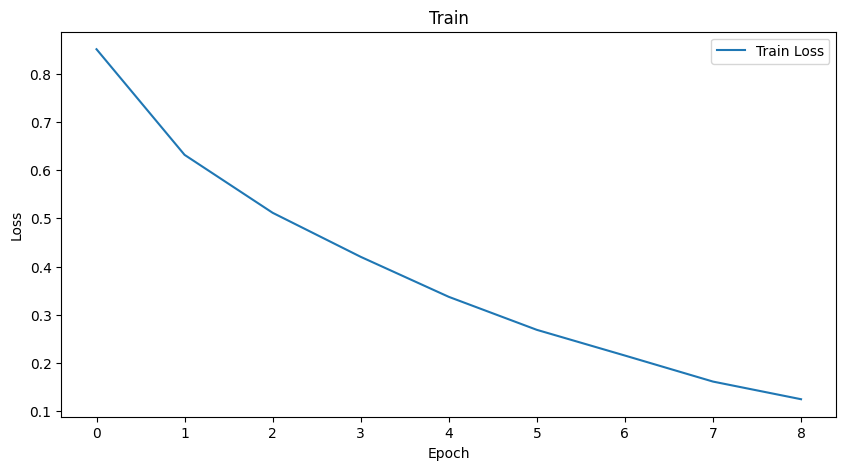

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses5, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

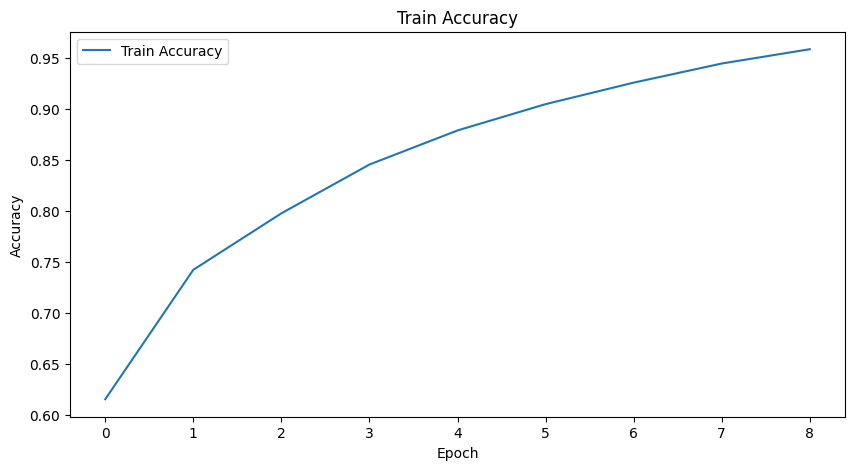

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies5, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/REVISI/result/IndoBERT_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader5, leave=True, total=len(test_loader5))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model5.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 84/84 [00:14<00:00,  5.80it/s]


Test Metrics: ACC:0.84 F1:0.84 REC:0.84 PRE:0.84


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses5)+1)),
    'train_loss': train_losses5,
    'train_accuracy': train_accuracies5,
    'valid_loss': valid_losses5,
    'valid_accuracy': valid_accuracies5
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert2_train_time],
    'peak_memory_MB': [indobert2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83       918
     neutral       0.81      0.81      0.81       697
    positive       0.87      0.87      0.87      1060

    accuracy                           0.84      2675
   macro avg       0.84      0.84      0.84      2675
weighted avg       0.84      0.84      0.84      2675



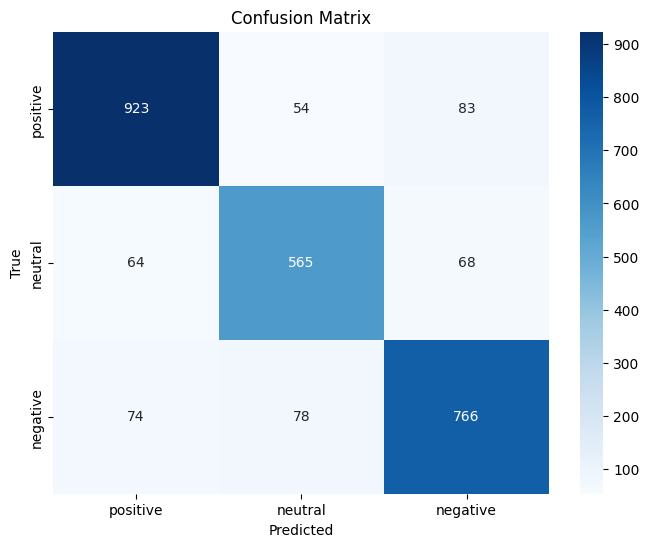

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : neutral (60.143%)


In [ ]:
text = 'sty stay'
subwords = tokenizer5.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model5.device)

logits = model5(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.841%)


# IndoBERT Large

In [ ]:
tokenizer6 = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config6 = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config6.num_labels = DocumentSentimentDataset.NUM_LABELS
model6 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config6)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model6

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
train_dataset6 = DocumentSentimentDataset(train_dataset_path, tokenizer6, lowercase=True)
valid_dataset6 = DocumentSentimentDataset(valid_dataset_path, tokenizer6, lowercase=True)
test_dataset6 = DocumentSentimentDataset(test_dataset_path, tokenizer6, lowercase=True)

train_loader6 = DocumentSentimentDataLoader(dataset=train_dataset6, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader6 = DocumentSentimentDataLoader(dataset=valid_dataset6, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader6 = DocumentSentimentDataLoader(dataset=test_dataset6, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (56.770%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (43.722%)


In [ ]:
optimizer = optim.Adam(model6.parameters(), lr=5e-5)
model = model6.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedua
train_losses6, train_accuracies6 = [], []
valid_losses6, valid_accuracies6 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader6, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader6)
    train_losses6.append(avg_train_loss)
    train_accuracies6.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader6, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        total_valid_loss += loss.item()
        list_hyp_valid += batch_hyp
        list_label_valid += batch_label

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader6)
    valid_losses6.append(avg_valid_loss)
    valid_accuracies6.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
indobert6_train_time = end_time - start_time
indobert6_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nIndoBERT3 - Waktu training: {indobert6_train_time:.2f} detik | Peak memory: {indobert6_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 84/84 [00:18<00:00,  4.60it/s]


Epoch 1/15 | Train Loss: 0.4583 | Train Acc: 0.8236 | Valid Loss: 0.2998 | Valid Acc: 0.8990

Epoch 2/15


Validating Epoch 2: 100%|██████████| 84/84 [00:18<00:00,  4.61it/s]


Epoch 2/15 | Train Loss: 0.2036 | Train Acc: 0.9250 | Valid Loss: 0.2732 | Valid Acc: 0.9073

Epoch 3/15


Validating Epoch 3: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s]


Epoch 3/15 | Train Loss: 0.1284 | Train Acc: 0.9561 | Valid Loss: 0.3526 | Valid Acc: 0.8934
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 4/15


Validating Epoch 4: 100%|██████████| 84/84 [00:17<00:00,  4.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/15 | Train Loss: 0.4950 | Train Acc: 0.7349 | Valid Loss: 1.0899 | Valid Acc: 0.3429
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s]

Epoch 5/15 | Train Loss: 1.1067 | Train Acc: 0.3741 | Valid Loss: 1.0845 | Valid Acc: 0.3960
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 5. Training dihentikan.

IndoBERT3 - Waktu training: 1270.19 detik | Peak memory: 11928.46 MB



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!nvidia-smi

Tue Jun 24 02:43:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |   14996MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

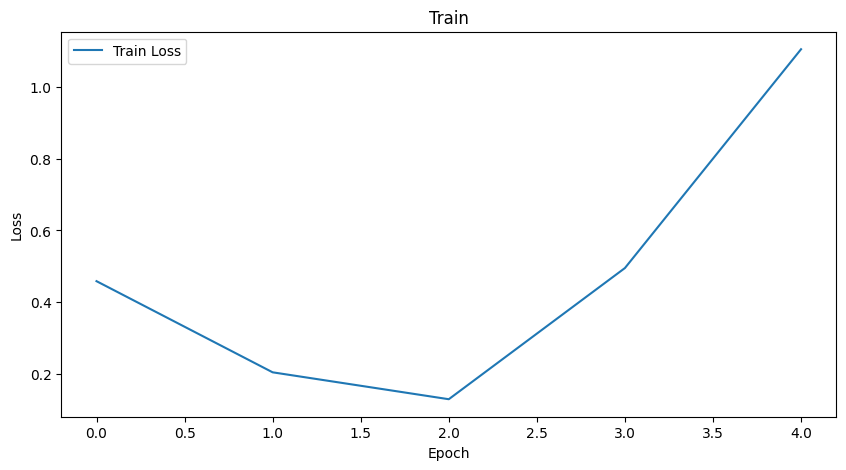

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses6, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

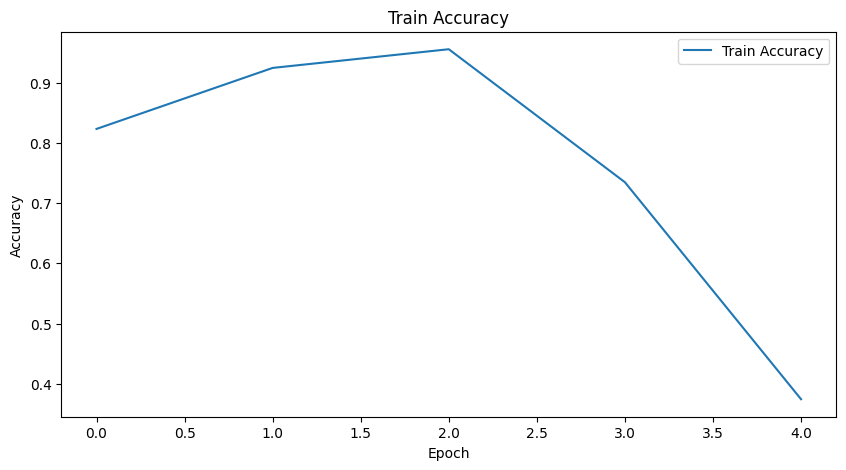

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies6, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/REVISI/result/IndoBERT_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader6, leave=True, total=len(test_loader6))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model6.csv'), index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 84/84 [00:15<00:00,  5.28it/s]


Test Metrics: ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses6)+1)),
    'train_loss': train_losses6,
    'train_accuracy': train_accuracies6,
    'valid_loss': valid_losses6,
    'valid_accuracy': valid_accuracies6
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['IndoBERT'],
    'train_time_seconds': [indobert6_train_time],
    'peak_memory_MB': [indobert6_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'IndoBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.89      0.88      0.89       918
     neutral       0.89      0.84      0.87       697
    positive       0.89      0.94      0.91      1060

    accuracy                           0.89      2675
   macro avg       0.89      0.89      0.89      2675
weighted avg       0.89      0.89      0.89      2675



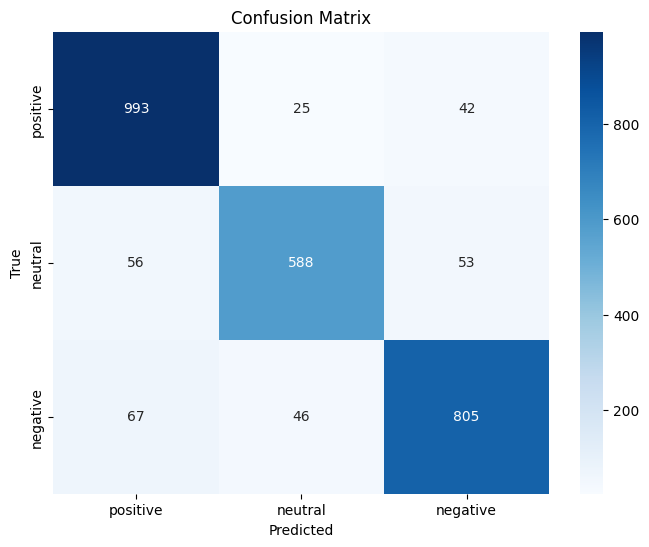

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (98.914%)


In [ ]:
text = 'jadi 😢'
subwords = tokenizer6.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model6.device)

logits = model6(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: jadi 😢 | Label : neutral (50.317%)


In [ ]:
model6.save_pretrained("model_indobert_sentimen")
tokenizer6.save_pretrained("model_indobert_sentimen")

('model_indobert_sentimen/tokenizer_config.json',
 'model_indobert_sentimen/special_tokens_map.json',
 'model_indobert_sentimen/vocab.txt',
 'model_indobert_sentimen/added_tokens.json')

In [ ]:
!zip -r /content/model_indobert_sentimen.zip /content/model_indobert_sentimen
from google.colab import files
files.download("/content/model_indobert_sentimen.zip")


  adding: content/model_indobert_sentimen/ (stored 0%)
  adding: content/model_indobert_sentimen/tokenizer_config.json (deflated 74%)
  adding: content/model_indobert_sentimen/special_tokens_map.json (deflated 42%)
  adding: content/model_indobert_sentimen/model.safetensors (deflated 7%)
  adding: content/model_indobert_sentimen/vocab.txt (deflated 53%)
  adding: content/model_indobert_sentimen/config.json (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DistilBERT

In [ ]:
tokenizer7 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config7 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config7.num_labels = DocumentSentimentDataset.NUM_LABELS
model7 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config7)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model7

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
count_param(model7)

135326979

In [ ]:
distilbert_param_count = count_param(model7, trainable=True)

In [ ]:
train_dataset7 = DocumentSentimentDataset(train_dataset_path, tokenizer7, lowercase=True)
valid_dataset7 = DocumentSentimentDataset(valid_dataset_path, tokenizer7, lowercase=True)
test_dataset7 = DocumentSentimentDataset(test_dataset_path, tokenizer7, lowercase=True)

train_loader7 = DocumentSentimentDataLoader(dataset=train_dataset7, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader7 = DocumentSentimentDataLoader(dataset=valid_dataset7, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader7 = DocumentSentimentDataLoader(dataset=test_dataset7, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (34.909%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : neutral (35.136%)


In [ ]:
optimizer = optim.Adam(model7.parameters(), lr=1e-5)
model = model7.cuda()

In [ ]:
# Metrik penyimpanan untuk model keempat
train_losses7, train_accuracies7 = [], []
valid_losses7, valid_accuracies7 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader7, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)

        outputs = model(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        # Fix: Access the first element of the list in batch_hyp and batch_label
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label] # Changed to access the first element

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader7)
    train_losses7.append(avg_train_loss)
    train_accuracies7.append(train_metrics['ACC'])

    # === VALIDATION ===
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader7, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)

        outputs = model(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        # Fix: Access the first element of the list in batch_hyp_valid and batch_label_valid
        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label] # Changed to access the first element

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader7)
    valid_losses7.append(avg_valid_loss)
    valid_accuracies7.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model.load_state_dict(best_model_state)

end_time = time.time()
distilbert1_train_time = end_time - start_time
distilbert1_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT1 - Waktu training: {distilbert1_train_time:.2f} detik | Peak memory: {distilbert1_peak_memory:.2f} MB")


Epoch 1/15


Validating Epoch 1: 100%|██████████| 84/84 [00:03<00:00, 21.41it/s]


Epoch 1/15 | Train Loss: 0.7478 | Train Acc: 0.6684 | Valid Loss: 0.5505 | Valid Acc: 0.7812

Epoch 2/15


Validating Epoch 2: 100%|██████████| 84/84 [00:03<00:00, 23.14it/s]


Epoch 2/15 | Train Loss: 0.4777 | Train Acc: 0.8182 | Valid Loss: 0.4241 | Valid Acc: 0.8418

Epoch 3/15


Validating Epoch 3: 100%|██████████| 84/84 [00:03<00:00, 22.95it/s]


Epoch 3/15 | Train Loss: 0.3445 | Train Acc: 0.8777 | Valid Loss: 0.4085 | Valid Acc: 0.8497

Epoch 4/15


Validating Epoch 4: 100%|██████████| 84/84 [00:03<00:00, 22.20it/s]


Epoch 4/15 | Train Loss: 0.2553 | Train Acc: 0.9115 | Valid Loss: 0.4062 | Valid Acc: 0.8605

Epoch 5/15


Validating Epoch 5: 100%|██████████| 84/84 [00:03<00:00, 23.26it/s]


Epoch 5/15 | Train Loss: 0.1910 | Train Acc: 0.9345 | Valid Loss: 0.4169 | Valid Acc: 0.8646
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 6/15


Validating Epoch 6: 100%|██████████| 84/84 [00:03<00:00, 21.53it/s]


Epoch 6/15 | Train Loss: 0.1519 | Train Acc: 0.9480 | Valid Loss: 0.3929 | Valid Acc: 0.8751

Epoch 7/15


Validating Epoch 7: 100%|██████████| 84/84 [00:03<00:00, 23.31it/s]


Epoch 7/15 | Train Loss: 0.1195 | Train Acc: 0.9584 | Valid Loss: 0.4394 | Valid Acc: 0.8672
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 84/84 [00:03<00:00, 23.25it/s]


Epoch 8/15 | Train Loss: 0.0959 | Train Acc: 0.9661 | Valid Loss: 0.4626 | Valid Acc: 0.8687
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 9/15


Validating Epoch 9: 100%|██████████| 84/84 [00:03<00:00, 21.89it/s]


Epoch 9/15 | Train Loss: 0.0856 | Train Acc: 0.9699 | Valid Loss: 0.4498 | Valid Acc: 0.8800
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 9. Training dihentikan.

DistilBERT1 - Waktu training: 525.73 detik | Peak memory: 6493.98 MB


In [ ]:
!nvidia-smi

Tue Jun 24 03:55:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             30W /   70W |    9318MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

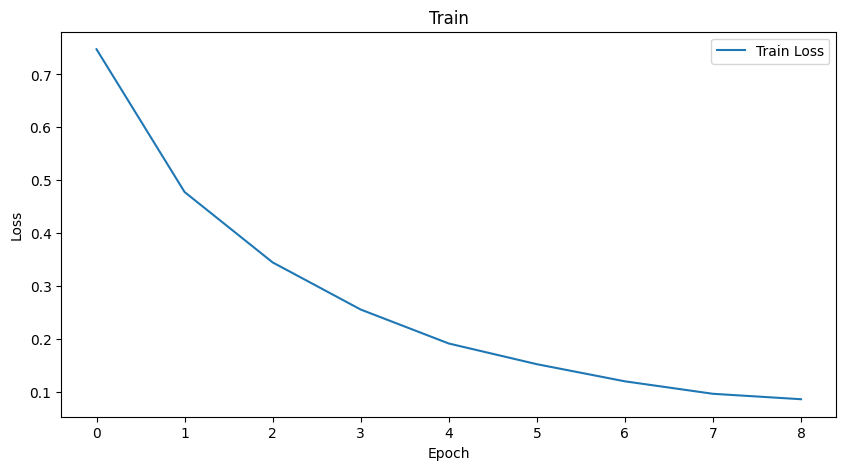

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses7, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

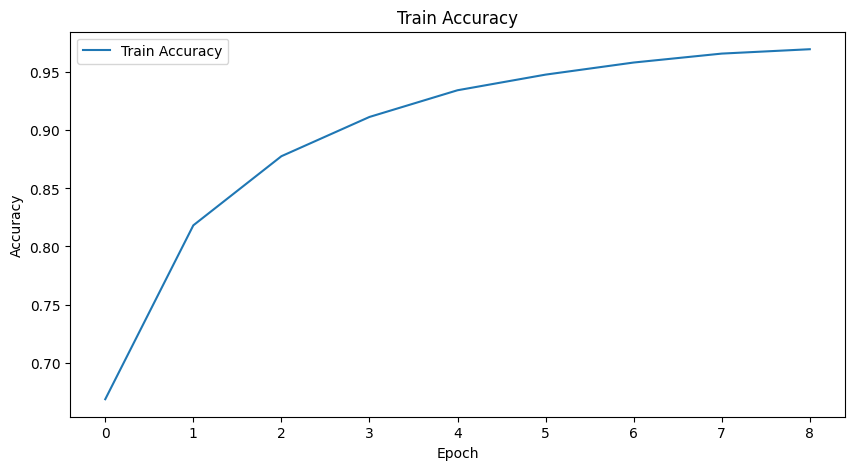

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies7, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/REVISI/result/DistilBERT_Results/1'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []
total_test_loss = 0 # Initialize total_test_loss here

test_pbar = tqdm(test_loader7, leave=True, total=len(test_loader7))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model7.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 84/84 [00:04<00:00, 20.21it/s]


Test Metrics: ACC:0.86 F1:0.86 REC:0.85 PRE:0.87


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses7)+1)),
    'train_loss': train_losses7,
    'train_accuracy': train_accuracies7,
    'valid_loss': valid_losses7,
    'valid_accuracy': valid_accuracies7
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert1_train_time],
    'peak_memory_MB': [distilbert1_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       918
     neutral       0.89      0.78      0.83       697
    positive       0.84      0.93      0.88      1060

    accuracy                           0.86      2675
   macro avg       0.87      0.85      0.86      2675
weighted avg       0.86      0.86      0.86      2675



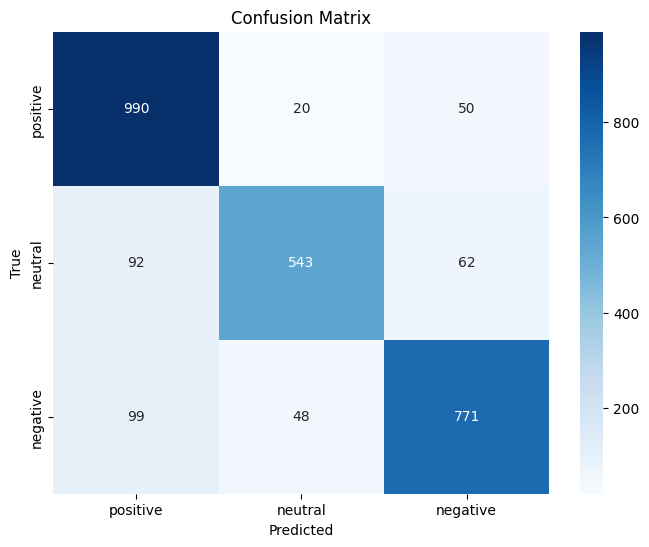

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (96.964%)


In [ ]:
text = 'sty stay'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.762%)


# DistilBERT

In [ ]:
tokenizer8 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config8 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config8.num_labels = DocumentSentimentDataset.NUM_LABELS
model8 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config8)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model8

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
train_dataset8 = DocumentSentimentDataset(train_dataset_path, tokenizer8, lowercase=True)
valid_dataset8 = DocumentSentimentDataset(valid_dataset_path, tokenizer8, lowercase=True)
test_dataset8 = DocumentSentimentDataset(test_dataset_path, tokenizer8, lowercase=True)

train_loader8 = DocumentSentimentDataLoader(dataset=train_dataset8, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader8 = DocumentSentimentDataLoader(dataset=valid_dataset8, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader8 = DocumentSentimentDataLoader(dataset=test_dataset8, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : positive (37.375%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : positive (35.739%)


In [ ]:
optimizer = optim.Adam(model8.parameters(), lr=3e-6)
model = model8.cuda()

In [ ]:
# Metrik penyimpanan untuk model kedelapan
train_losses8, train_accuracies8 = [], []
valid_losses8, valid_accuracies8 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model8.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader8, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model8.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model8.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model8.device)

        outputs = model8(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label]

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader8)
    train_losses8.append(avg_train_loss)
    train_accuracies8.append(train_metrics['ACC'])

    # === VALIDATION ===
    model8.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader8, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model8.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model8.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model8.device)

        outputs = model8(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label]

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader8)
    valid_losses8.append(avg_valid_loss)
    valid_accuracies8.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model8.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model8.load_state_dict(best_model_state)

end_time = time.time()
distilbert2_train_time = end_time - start_time
distilbert2_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT2 - Waktu training: {distilbert2_train_time:.2f} detik | Peak memory: {distilbert2_peak_memory:.2f} MB")



Epoch 1/15


Validating Epoch 1: 100%|██████████| 90/90 [00:04<00:00, 21.48it/s]


Epoch 1/15 | Train Loss: 0.9365 | Train Acc: 0.5396 | Valid Loss: 0.7570 | Valid Acc: 0.6845

Epoch 2/15


Validating Epoch 2: 100%|██████████| 90/90 [00:03<00:00, 22.67it/s]


Epoch 2/15 | Train Loss: 0.6758 | Train Acc: 0.7230 | Valid Loss: 0.6008 | Valid Acc: 0.7585

Epoch 3/15


Validating Epoch 3: 100%|██████████| 90/90 [00:03<00:00, 23.95it/s]


Epoch 3/15 | Train Loss: 0.5530 | Train Acc: 0.7862 | Valid Loss: 0.5286 | Valid Acc: 0.7995

Epoch 4/15


Validating Epoch 4: 100%|██████████| 90/90 [00:03<00:00, 23.62it/s]


Epoch 4/15 | Train Loss: 0.4737 | Train Acc: 0.8251 | Valid Loss: 0.4891 | Valid Acc: 0.8223

Epoch 5/15


Validating Epoch 5: 100%|██████████| 90/90 [00:03<00:00, 22.67it/s]


Epoch 5/15 | Train Loss: 0.4178 | Train Acc: 0.8489 | Valid Loss: 0.4719 | Valid Acc: 0.8223

Epoch 6/15


Validating Epoch 6: 100%|██████████| 90/90 [00:03<00:00, 23.27it/s]


Epoch 6/15 | Train Loss: 0.3747 | Train Acc: 0.8627 | Valid Loss: 0.4509 | Valid Acc: 0.8342

Epoch 7/15


Validating Epoch 7: 100%|██████████| 90/90 [00:03<00:00, 23.72it/s]


Epoch 7/15 | Train Loss: 0.3345 | Train Acc: 0.8798 | Valid Loss: 0.4517 | Valid Acc: 0.8363
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 8/15


Validating Epoch 8: 100%|██████████| 90/90 [00:03<00:00, 23.54it/s]


Epoch 8/15 | Train Loss: 0.3007 | Train Acc: 0.8953 | Valid Loss: 0.4474 | Valid Acc: 0.8440

Epoch 9/15


Validating Epoch 9: 100%|██████████| 90/90 [00:03<00:00, 22.53it/s]


Epoch 9/15 | Train Loss: 0.2722 | Train Acc: 0.9070 | Valid Loss: 0.4429 | Valid Acc: 0.8416

Epoch 10/15


Validating Epoch 10: 100%|██████████| 90/90 [00:03<00:00, 23.96it/s]


Epoch 10/15 | Train Loss: 0.2456 | Train Acc: 0.9172 | Valid Loss: 0.4358 | Valid Acc: 0.8531

Epoch 11/15


Validating Epoch 11: 100%|██████████| 90/90 [00:03<00:00, 23.96it/s]


Epoch 11/15 | Train Loss: 0.2108 | Train Acc: 0.9274 | Valid Loss: 0.4276 | Valid Acc: 0.8594

Epoch 12/15


Validating Epoch 12: 100%|██████████| 90/90 [00:03<00:00, 22.80it/s]


Epoch 12/15 | Train Loss: 0.1953 | Train Acc: 0.9344 | Valid Loss: 0.4398 | Valid Acc: 0.8598
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 13/15


Validating Epoch 13: 100%|██████████| 90/90 [00:03<00:00, 23.62it/s]


Epoch 13/15 | Train Loss: 0.1786 | Train Acc: 0.9406 | Valid Loss: 0.4509 | Valid Acc: 0.8633
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 14/15


Validating Epoch 14: 100%|██████████| 90/90 [00:03<00:00, 23.93it/s]

Epoch 14/15 | Train Loss: 0.1647 | Train Acc: 0.9444 | Valid Loss: 0.4432 | Valid Acc: 0.8573
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 14. Training dihentikan.

DistilBERT2 - Waktu training: 790.80 detik | Peak memory: 4995.85 MB


In [ ]:
!nvidia-smi

Sun Jun 22 02:48:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             32W /   70W |    5836MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

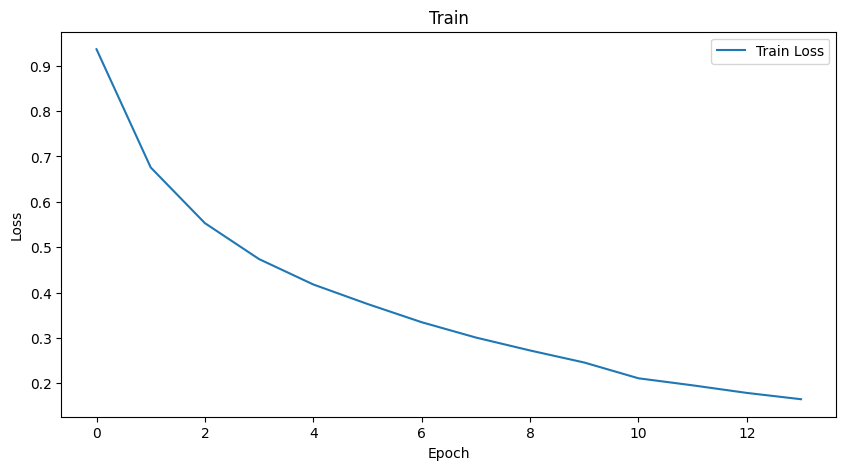

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses8, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

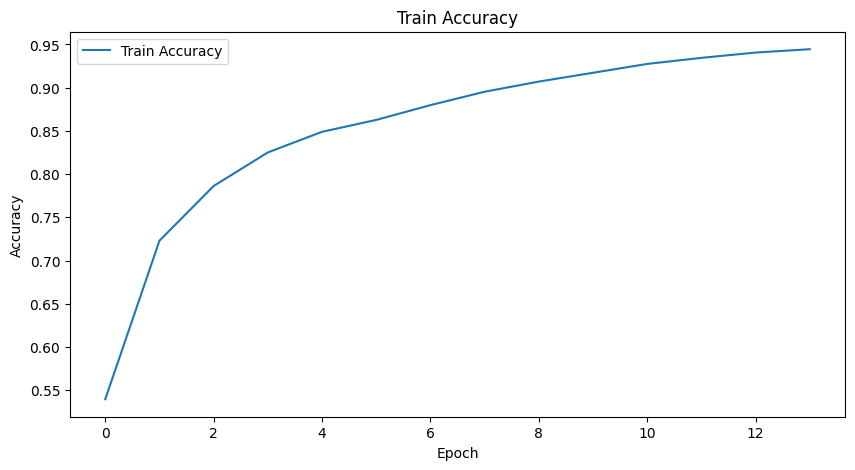

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies8, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/20rb/result4/DistilBERT_Results/2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader8, leave=True, total=len(test_loader8))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model8.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 112/112 [00:04<00:00, 23.59it/s]



Test Metrics: ACC:0.86 F1:0.85 REC:0.85 PRE:0.86


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses8)+1)),
    'train_loss': train_losses8,
    'train_accuracy': train_accuracies8,
    'valid_loss': valid_losses8,
    'valid_accuracy': valid_accuracies8
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert2_train_time],
    'peak_memory_MB': [distilbert2_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.86      1230
     neutral       0.86      0.81      0.83       968
    positive       0.88      0.86      0.87      1368

    accuracy                           0.86      3566
   macro avg       0.86      0.85      0.85      3566
weighted avg       0.86      0.86      0.86      3566



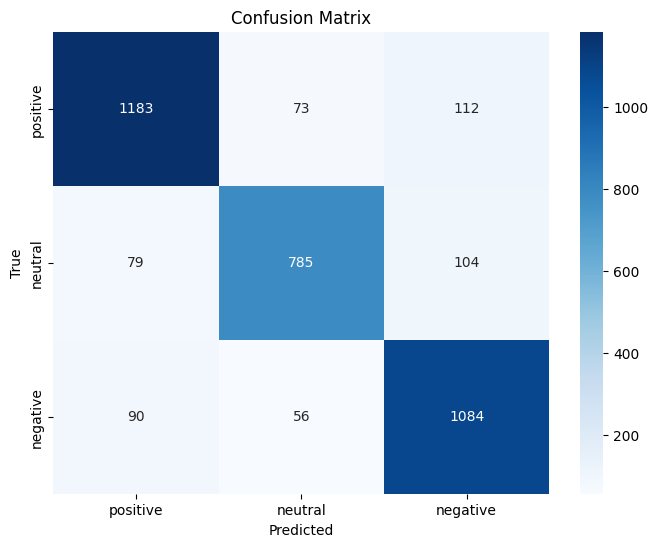

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (98.372%)


In [ ]:
text = 'sty stay'
subwords = tokenizer8.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model8.device)

logits = model8(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : neutral (99.659%)


# DistilBERT

In [ ]:
tokenizer9 = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config9 = DistilBertConfig.from_pretrained('distilbert/distilbert-base-multilingual-cased')
config9.num_labels = DocumentSentimentDataset.NUM_LABELS
model9 = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-multilingual-cased', config=config9)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset9 = DocumentSentimentDataset(train_dataset_path, tokenizer9, lowercase=True)
valid_dataset9 = DocumentSentimentDataset(valid_dataset_path, tokenizer9, lowercase=True)
test_dataset9 = DocumentSentimentDataset(test_dataset_path, tokenizer9, lowercase=True)

train_loader9 = DocumentSentimentDataLoader(dataset=train_dataset9, max_seq_len=256, batch_size=32, num_workers=2, shuffle=True)
valid_loader9 = DocumentSentimentDataLoader(dataset=valid_dataset9, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)
test_loader9 = DocumentSentimentDataLoader(dataset=test_dataset9, max_seq_len=256, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (34.742%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : neutral (34.541%)


In [ ]:
optimizer = optim.Adam(model9.parameters(), lr=5e-5)
model = model9.cuda()

In [ ]:
# Metrik penyimpanan
train_losses9, train_accuracies9 = [], []
valid_losses9, valid_accuracies9 = [], []

# Early stopping
patience = 3
best_valid_loss = float('inf')
best_model_state = None
counter = 0

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

n_epochs = 15

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # === TRAINING ===
    model9.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp = []  # Initialize list_hyp as an empty list
    list_label = [] # Initialize list_label as an empty list

    train_pbar = tqdm(train_loader9, desc=f"Training Epoch {epoch+1}", leave=True)
    for i, batch_data in enumerate(train_pbar):
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model9.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model9.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model9.device)

        outputs = model9(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
        list_hyp_str = [id2label[i] for i in batch_hyp]
        list_label_str = [id2label[i[0]] for i in batch_label]

        list_hyp.extend(list_hyp_str)
        list_label.extend(list_label_str)

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    avg_train_loss = total_train_loss / len(train_loader9)
    train_losses9.append(avg_train_loss)
    train_accuracies9.append(train_metrics['ACC'])

    # === VALIDATION ===
    model9.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp_valid, list_label_valid = [], []

    valid_pbar = tqdm(valid_loader9, desc=f"Validating Epoch {epoch+1}", leave=True)
    for batch_data in valid_pbar:
        batch_inputs = {
            "input_ids": torch.tensor(batch_data[0]).to(model9.device),
            "attention_mask": torch.tensor(batch_data[1]).to(model9.device),
        }
        if len(batch_data) > 2:
            batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model9.device)

        outputs = model9(**batch_inputs)
        loss = outputs.loss
        logits = outputs.logits

        total_valid_loss += loss.item()

        batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
        batch_label = batch_inputs["labels"].cpu().tolist()

        list_hyp_valid += [id2label[i] for i in batch_hyp]
        list_label_valid += [id2label[i[0]] for i in batch_label]

    valid_metrics = document_sentiment_metrics_fn(list_hyp_valid, list_label_valid)
    avg_valid_loss = total_valid_loss / len(valid_loader9)
    valid_losses9.append(avg_valid_loss)
    valid_accuracies9.append(valid_metrics['ACC'])

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_metrics['ACC']:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_metrics['ACC']:.4f}")

    # === EARLY STOPPING ===
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state = copy.deepcopy(model9.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"Valid loss tidak membaik selama {counter} epoch berturut-turut.")
        if counter >= patience:
            print(f"Early stopping aktif di epoch {epoch+1}. Training dihentikan.")
            break

# Load model terbaik
if best_model_state is not None:
    model9.load_state_dict(best_model_state)

end_time = time.time()
distilbert3_train_time = end_time - start_time
distilbert3_peak_memory = torch.cuda.max_memory_allocated() / 1024**2

print(f"\nDistilBERT3 - Waktu training: {distilbert3_train_time:.2f} detik | Peak memory: {distilbert3_peak_memory:.2f} MB")


Epoch 1/15


Validating Epoch 1: 100%|██████████| 84/84 [00:04<00:00, 18.13it/s]


Epoch 1/15 | Train Loss: 0.5873 | Train Acc: 0.7535 | Valid Loss: 0.4101 | Valid Acc: 0.8530

Epoch 2/15


Validating Epoch 2: 100%|██████████| 84/84 [00:04<00:00, 20.84it/s]


Epoch 2/15 | Train Loss: 0.3067 | Train Acc: 0.8898 | Valid Loss: 0.3639 | Valid Acc: 0.8762

Epoch 3/15


Validating Epoch 3: 100%|██████████| 84/84 [00:03<00:00, 21.67it/s]


Epoch 3/15 | Train Loss: 0.1981 | Train Acc: 0.9276 | Valid Loss: 0.3396 | Valid Acc: 0.8874

Epoch 4/15


Validating Epoch 4: 100%|██████████| 84/84 [00:03<00:00, 21.74it/s]


Epoch 4/15 | Train Loss: 0.1361 | Train Acc: 0.9526 | Valid Loss: 0.3658 | Valid Acc: 0.8908
Valid loss tidak membaik selama 1 epoch berturut-turut.

Epoch 5/15


Validating Epoch 5: 100%|██████████| 84/84 [00:03<00:00, 21.12it/s]


Epoch 5/15 | Train Loss: 0.1078 | Train Acc: 0.9643 | Valid Loss: 0.4000 | Valid Acc: 0.8915
Valid loss tidak membaik selama 2 epoch berturut-turut.

Epoch 6/15


Validating Epoch 6: 100%|██████████| 84/84 [00:03<00:00, 21.70it/s]


Epoch 6/15 | Train Loss: 0.0820 | Train Acc: 0.9703 | Valid Loss: 0.3903 | Valid Acc: 0.8994
Valid loss tidak membaik selama 3 epoch berturut-turut.
Early stopping aktif di epoch 6. Training dihentikan.

DistilBERT3 - Waktu training: 365.17 detik | Peak memory: 7487.42 MB


In [ ]:
!nvidia-smi

Tue Jun 24 02:52:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |   10446MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

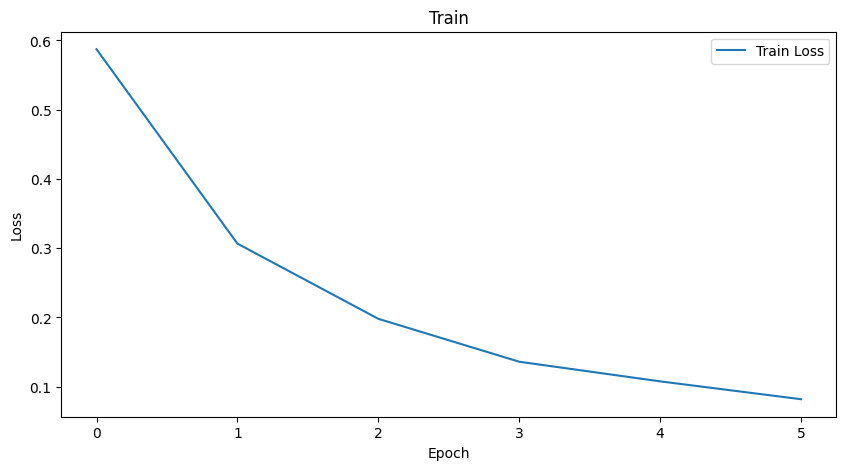

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses9, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

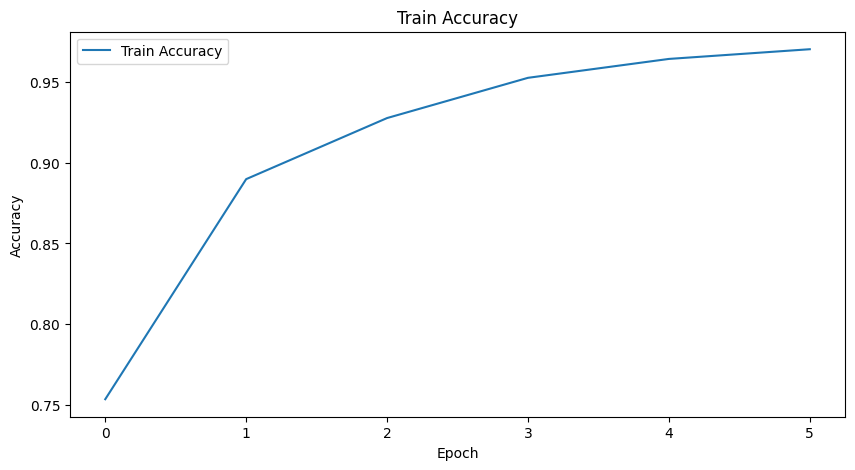

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies9, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
output_dir = '/content/drive/MyDrive/Skripsi/Piala_Asia/REVISI/result/DistilBERT_Results/3'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
list_hyp, list_label = [], []
all_texts = []
total_test_loss = 0  # Initialize total_test_loss

test_pbar = tqdm(test_loader9, leave=True, total=len(test_loader9))
for i, batch_data in enumerate(test_pbar):
    batch_inputs = {
        "input_ids": torch.tensor(batch_data[0]).to(model.device),
        "attention_mask": torch.tensor(batch_data[1]).to(model.device),
    }

    if len(batch_data) > 2:
        batch_inputs["labels"] = torch.tensor(batch_data[2]).to(model.device)
        batch_texts = batch_data[-1]  # Ambil teks dari batch (asumsinya di posisi terakhir)

    outputs = model(**batch_inputs)
    loss = outputs.loss
    logits = outputs.logits

    total_test_loss += loss.item()

    batch_hyp = torch.argmax(logits, dim=1).cpu().tolist()
    batch_label = batch_inputs["labels"].cpu().tolist()

    # Flatten batch_label if it's a list of lists
    batch_label = [item for sublist in batch_label for item in sublist]

    id2label = {0: 'positive', 1: 'neutral', 2: 'negative'}
    batch_label_str = [id2label[i] for i in batch_label]
    batch_hyp_str = [id2label[i] for i in batch_hyp]

    list_hyp.extend(batch_hyp_str)
    list_label.extend(batch_label_str)
    all_texts.extend(batch_texts)

# Simpan hasil ke CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})
df_result.to_csv(os.path.join(output_dir,'hasil_prediksi_model9.csv'), index=False)

# Hitung metrik evaluasi
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'\nTest Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 84/84 [00:03<00:00, 21.35it/s]


Test Metrics: ACC:0.87 F1:0.87 REC:0.86 PRE:0.88


In [ ]:
# === SIMPAN METRIK PER EPOCH ===
df_metrics_epoch = pd.DataFrame({
    'epoch': list(range(1, len(train_losses9)+1)),
    'train_loss': train_losses9,
    'train_accuracy': train_accuracies9,
    'valid_loss': valid_losses9,
    'valid_accuracy': valid_accuracies9
})
df_metrics_epoch.to_csv(os.path.join(output_dir,'metrics_per_epoch.csv'), index=False)

# === SIMPAN WAKTU DAN MEMORI ===
df_time_memory = pd.DataFrame({
    'model': ['DistilBERT'],
    'train_time_seconds': [distilbert3_train_time],
    'peak_memory_MB': [distilbert3_peak_memory]
})
df_time_memory.to_csv(os.path.join(output_dir,'time_memory.csv'), index=False)

# === SIMPAN METRIK TEST ===
test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_metrics_dict = {
    'model': 'DistilBERT',
    **test_metrics
}
df_test_metrics = pd.DataFrame([test_metrics_dict])
df_test_metrics.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=False)

# === SIMPAN CLASSIFICATION REPORT ===
report_dict = classification_report(list_label, list_hyp, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv(os.path.join(output_dir,'classification_report.csv'))

In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.91      0.83      0.87       918
     neutral       0.89      0.81      0.85       697
    positive       0.84      0.95      0.89      1060

    accuracy                           0.87      2675
   macro avg       0.88      0.86      0.87      2675
weighted avg       0.88      0.87      0.87      2675



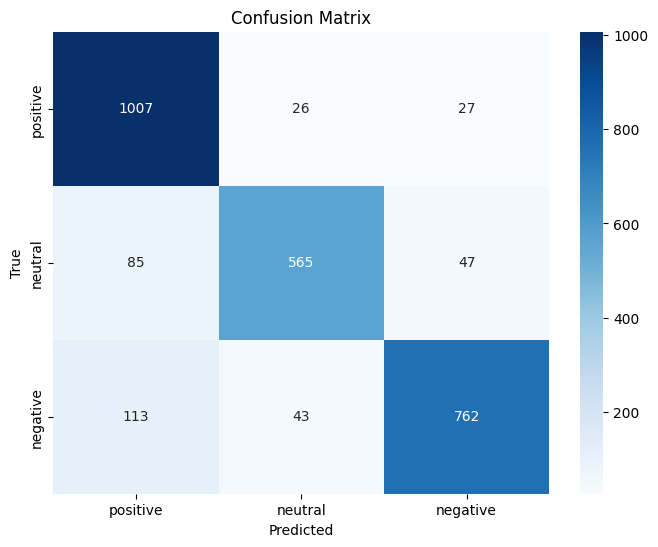

In [ ]:
# === SIMPAN CONFUSION MATRIX ===
labels = list(w2i.keys())
cm = confusion_matrix(list_label, list_hyp, labels=labels)
df_conf_matrix = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
df_conf_matrix.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

# === TAMPILKAN CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (99.828%)


In [ ]:
text = 'sty stay'
subwords = tokenizer9.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model9.device)

logits = model9(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (99.839%)


In [ ]:
model9.save_pretrained("model_distilbert_sentimen")
tokenizer9.save_pretrained("model_distilbert_sentimen")

('model_distilbert_sentimen/tokenizer_config.json',
 'model_distilbert_sentimen/special_tokens_map.json',
 'model_distilbert_sentimen/vocab.txt',
 'model_distilbert_sentimen/added_tokens.json')

In [ ]:
!zip -r /content/model_distilbert_sentimen.zip /content/model_distilbert_sentimen
from google.colab import files
files.download("/content/model_distilbert_sentimen.zip")


  adding: content/model_distilbert_sentimen/ (stored 0%)
  adding: content/model_distilbert_sentimen/tokenizer_config.json (deflated 75%)
  adding: content/model_distilbert_sentimen/special_tokens_map.json (deflated 42%)
  adding: content/model_distilbert_sentimen/model.safetensors (deflated 7%)
  adding: content/model_distilbert_sentimen/vocab.txt (deflated 45%)
  adding: content/model_distilbert_sentimen/config.json (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# visualisasi

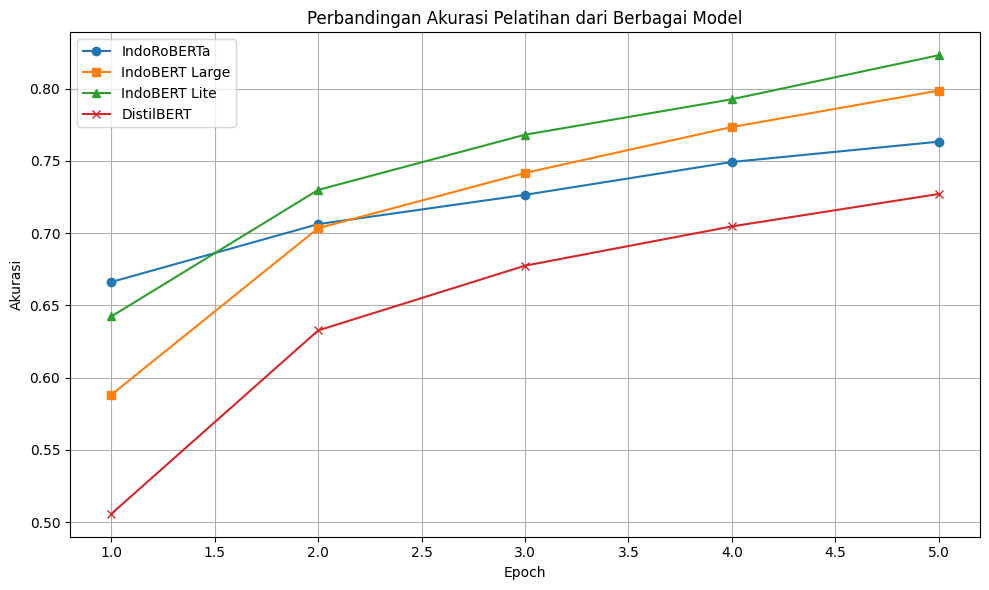

In [ ]:
import matplotlib.pyplot as plt

# Misal data sudah tersedia: train_accuracies1, train_accuracies2, train_accuracies3, train_accuracies4
epochs = range(1, len(train_accuracies1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies1, marker='o', label='IndoRoBERTa')
plt.plot(epochs, train_accuracies2, marker='s', label='IndoBERT Large')
plt.plot(epochs, train_accuracies3, marker='^', label='IndoBERT Lite')
plt.plot(epochs, train_accuracies4, marker='x', label='DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Pelatihan dari Berbagai Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



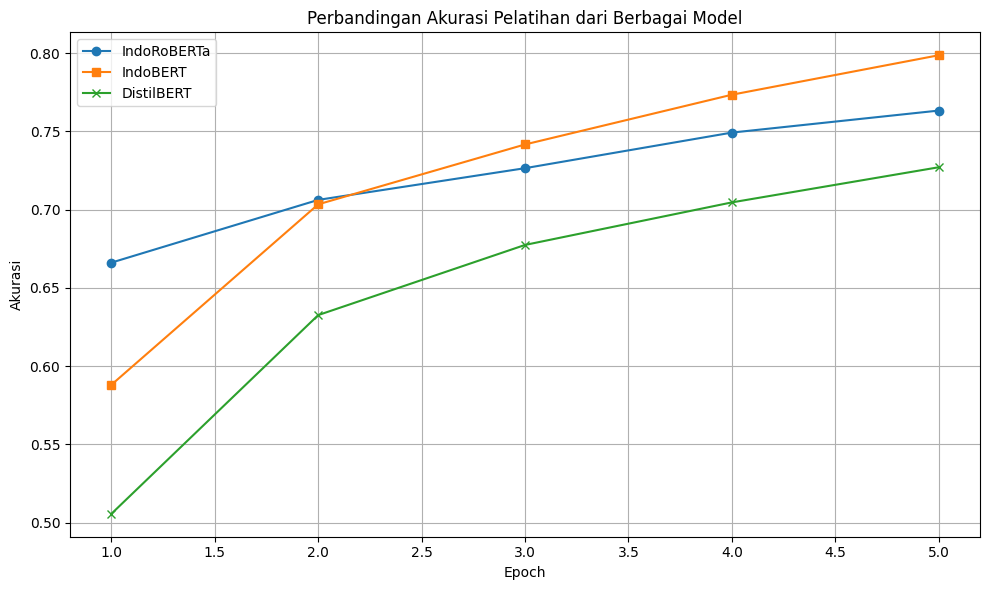

In [ ]:
import matplotlib.pyplot as plt

# Misal data sudah tersedia: train_accuracies1, train_accuracies2, train_accuracies3, train_accuracies4
epochs = range(1, len(train_accuracies1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies1, marker='o', label='IndoRoBERTa')
plt.plot(epochs, train_accuracies2, marker='s', label='IndoBERT')
plt.plot(epochs, train_accuracies4, marker='x', label='DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Pelatihan dari Berbagai Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



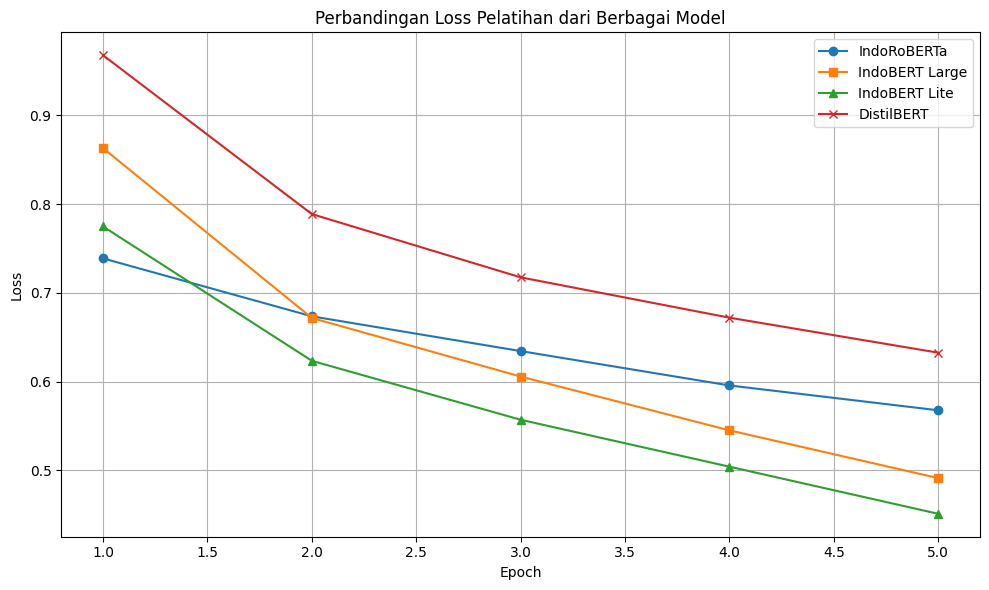

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses1, marker='o', label='IndoRoBERTa')
plt.plot(epochs, train_losses2, marker='s', label='IndoBERT Large')
plt.plot(epochs, train_losses3, marker='^', label='IndoBERT Lite')
plt.plot(epochs, train_losses4, marker='x', label='DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perbandingan Loss Pelatihan dari Berbagai Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

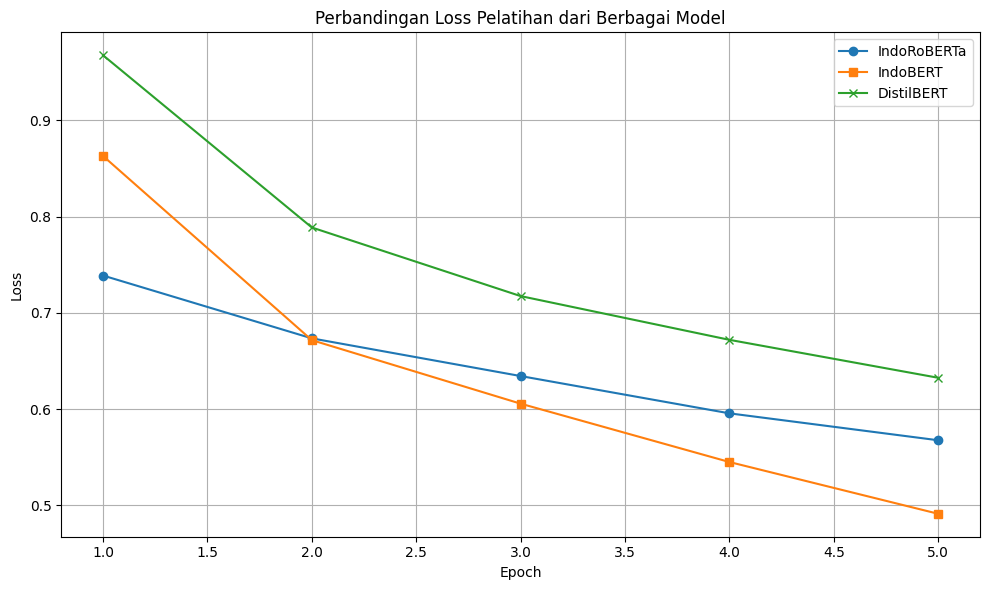

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses1, marker='o', label='IndoRoBERTa')
plt.plot(epochs, train_losses2, marker='s', label='IndoBERT')
plt.plot(epochs, train_losses4, marker='x', label='DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perbandingan Loss Pelatihan dari Berbagai Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: (2, 4)

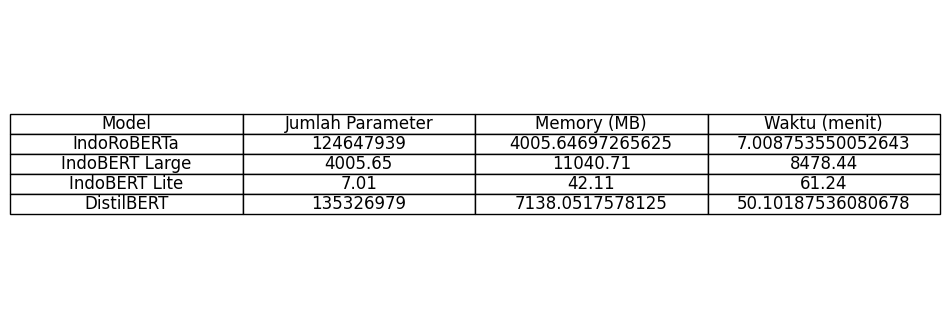

In [ ]:
# prompt: Buaktan visualisasi tabel untuk jumlah param, memory, waktu, jadikan menit, dan untuk ukuran memory. digit belakang koma 2  saja untuk ukuran memory dan proses

import pandas as pd
import matplotlib.pyplot as plt

# Data for the table (replace with your actual data)
data = {
    'Model': ['IndoRoBERTa', 'IndoBERT Large', 'IndoBERT Lite', 'DistilBERT'],
    'Jumlah Parameter': [indoroberta_param_count, indobertLarge_param_count, indobertLite_param_count, distilbert_param_count],
    'Memory (MB)': [indoroberta_peak_memory, indobertLarge_peak_memory, indobertLite_peak_memory, distilbert_peak_memory],
    'Waktu (menit)': [indoroberta_train_time/60, indobertLarge_train_time/60, indobertLite_train_time/60, distilbert_train_time/60],
}

df = pd.DataFrame(data)

# Create the table visualization
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
ax = plt.gca()
ax.axis('off')  # Hide axis
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust table scale as needed


# Format memory and time columns to two decimal places
for i in range(len(df)):
  table[2, i+1].get_text().set_text(f"{df['Memory (MB)'][i]:.2f}")
  table[3, i+1].get_text().set_text(f"{df['Waktu (menit)'][i]:.2f}")


plt.title('Perbandingan Model', fontsize=14)
plt.show()


            Model  Jumlah Parameter  Waktu Training (menit)  Memory Peak (MB)
0     IndoRoBERTa         124647939                    7.01           4005.65
1  IndoBERT Large         335144963                    6.77           8420.51
2   IndoBERT Lite         124443651                    6.78           8425.87
3      DistilBERT         135326979                    4.15           7611.18


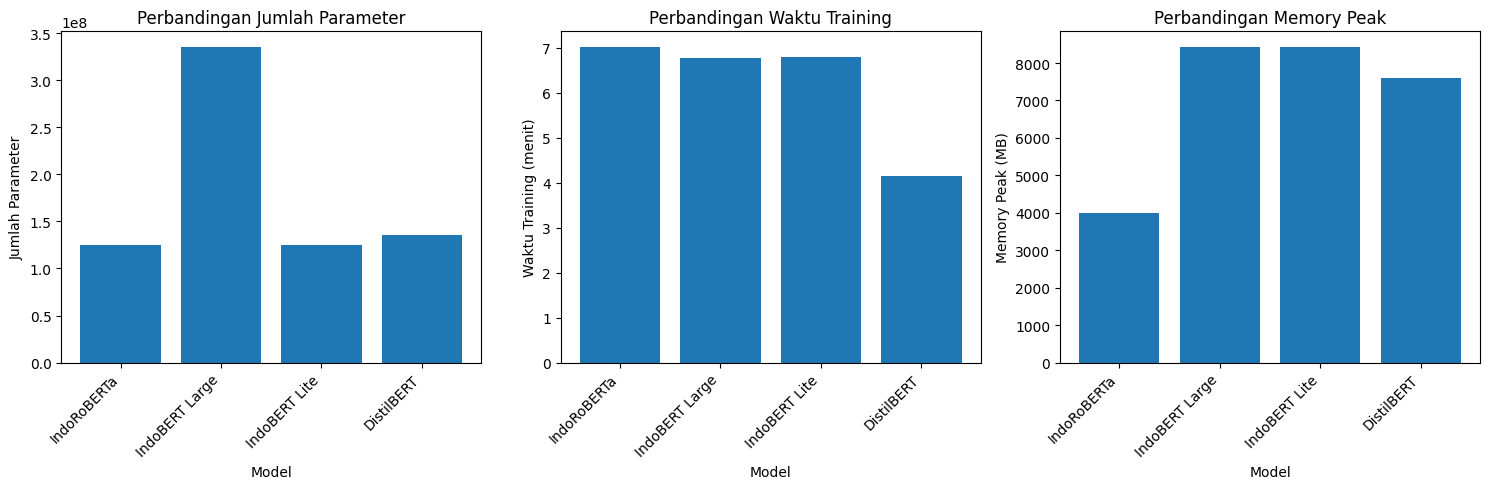

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data awal (ganti dengan nilai aktual kamu)
models = ['IndoRoBERTa', 'IndoBERT Large', 'IndoBERT Lite', 'DistilBERT']
params = [indoroberta_param_count, indobertLarge_param_count, indobertLite_param_count, distilbert_param_count]
times = [indoroberta_train_time, indobertLarge_train_time, indobertLite_train_time, distilbert_train_time]
memory = [indoroberta_peak_memory, indobertLarge_peak_memory, indobertLite_peak_memory, distilbert_peak_memory]

# Konversi waktu ke menit dan memory ke 2 digit desimal
times_in_minutes = [round(t / 60, 2) for t in times]
memory_rounded = [round(m, 2) for m in memory]

# Membuat DataFrame
data = {
    'Model': models,
    'Jumlah Parameter': params,
    'Waktu Training (menit)': times_in_minutes,
    'Memory Peak (MB)': memory_rounded
}
df = pd.DataFrame(data)

# Tampilkan tabel
print(df)

# Visualisasi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(df['Model'], df['Jumlah Parameter'])
plt.xlabel('Model')
plt.ylabel('Jumlah Parameter')
plt.title('Perbandingan Jumlah Parameter')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
plt.bar(df['Model'], df['Waktu Training (menit)'])
plt.xlabel('Model')
plt.ylabel('Waktu Training (menit)')
plt.title('Perbandingan Waktu Training')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
plt.bar(df['Model'], df['Memory Peak (MB)'])
plt.xlabel('Model')
plt.ylabel('Memory Peak (MB)')
plt.title('Perbandingan Memory Peak')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


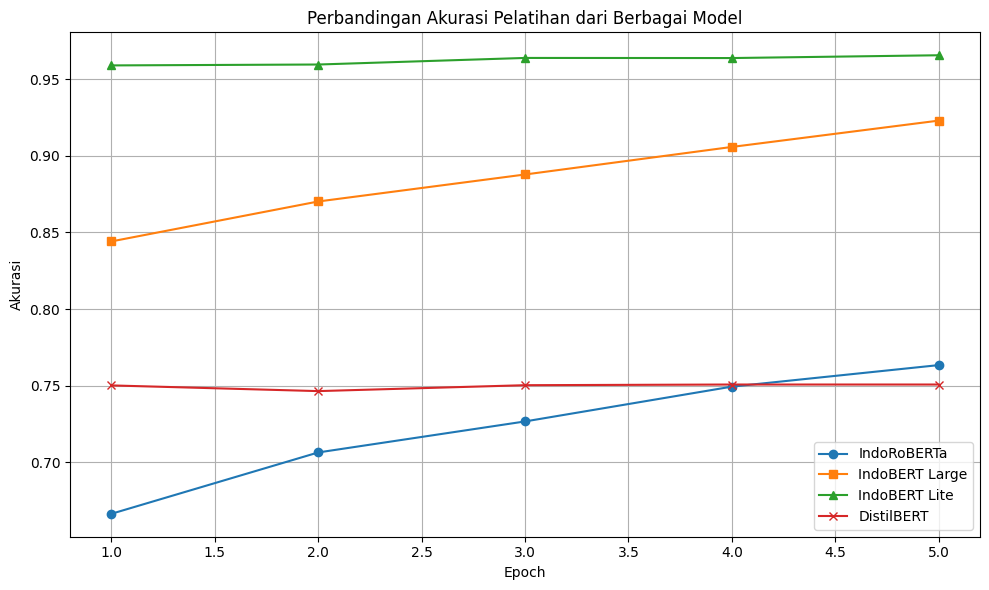

In [ ]:
import matplotlib.pyplot as plt

# Misal data sudah tersedia: train_accuracies1, train_accuracies2, train_accuracies3, train_accuracies4
epochs = range(1, len(train_accuracies1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies1, marker='o', label='IndoRoBERTa')
plt.plot(epochs, train_accuracies2, marker='s', label='IndoBERT Large')
plt.plot(epochs, train_accuracies3, marker='^', label='IndoBERT Lite')
plt.plot(epochs, train_accuracies4, marker='x', label='DistilBERT')

plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Pelatihan dari Berbagai Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



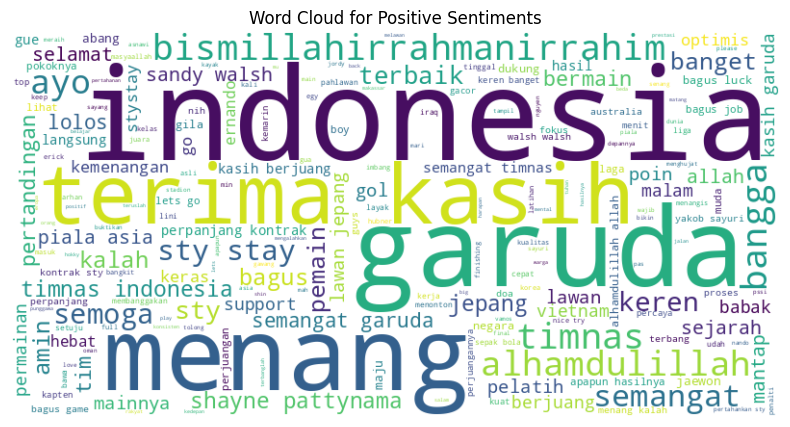

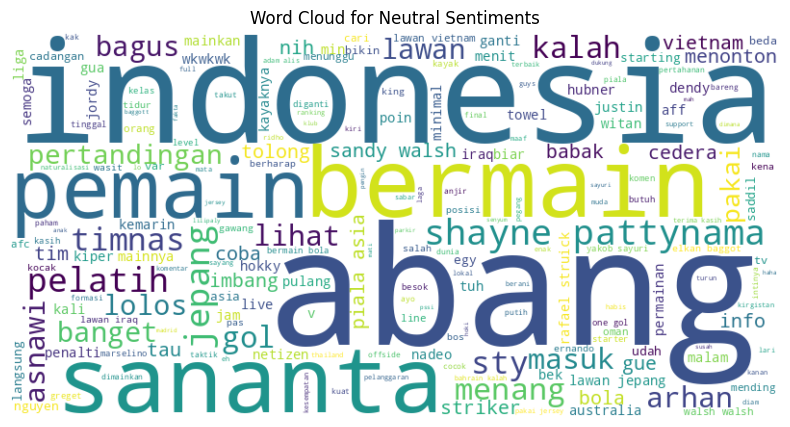

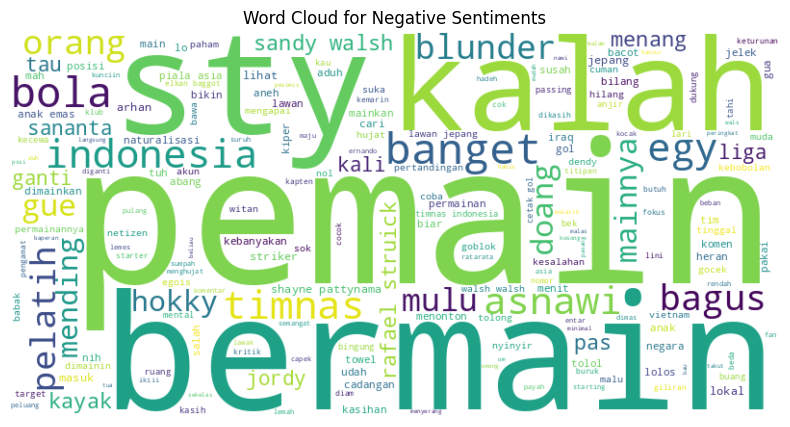

In [ ]:
# prompt: buaktan word clouds untuk setiap sentiment

!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load hasil prediksi
df_result = pd.read_csv('hasil_prediksi_model1.csv')  # Ganti dengan nama file yang sesuai

# Pisahkan teks berdasarkan sentimen
positive_texts = ' '.join(df_result[df_result['predicted_label'] == 'positive']['text'].tolist())
neutral_texts = ' '.join(df_result[df_result['predicted_label'] == 'neutral']['text'].tolist())
negative_texts = ' '.join(df_result[df_result['predicted_label'] == 'negative']['text'].tolist())

# Buat word cloud untuk setiap sentimen
sentiments = ['positive', 'neutral', 'negative']
texts = [positive_texts, neutral_texts, negative_texts]

for sentiment, text in zip(sentiments, texts):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiments')
    plt.show()


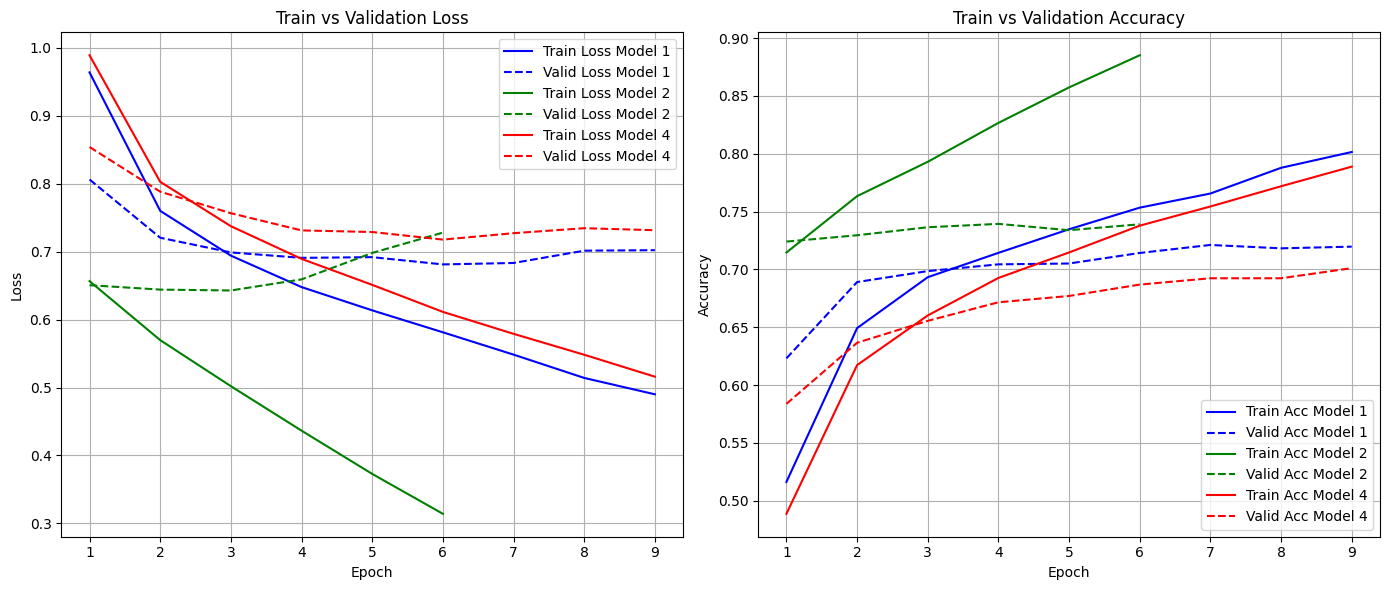

In [ ]:
import matplotlib.pyplot as plt

# Asumsi semua model memiliki jumlah epoch yang sama
# epochs = range(1, len(train_losses1) + 1) # Remove this line

plt.figure(figsize=(14, 6))

# === LOSS ===
plt.subplot(1, 2, 1)
# Determine the actual number of epochs for each model based on the list lengths
epochs1 = range(1, len(train_losses1) + 1)
epochs2 = range(1, len(train_losses2) + 1)
epochs4 = range(1, len(train_losses4) + 1) # Assuming train_losses4 exists from earlier runs

plt.plot(epochs1, train_losses1, 'b-', label='Train Loss Model 1')
plt.plot(epochs1, valid_losses1, 'b--', label='Valid Loss Model 1')
plt.plot(epochs2, train_losses2, 'g-', label='Train Loss Model 2')
plt.plot(epochs2, valid_losses2, 'g--', label='Valid Loss Model 2')
plt.plot(epochs4, train_losses4, 'r-', label='Train Loss Model 4')
plt.plot(epochs4, valid_losses4, 'r--', label='Valid Loss Model 4')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# === ACCURACY ===
plt.subplot(1, 2, 2)
# Use the determined epochs lists for plotting accuracy as well
plt.plot(epochs1, train_accuracies1, 'b-', label='Train Acc Model 1')
plt.plot(epochs1, valid_accuracies1, 'b--', label='Valid Acc Model 1')
plt.plot(epochs2, train_accuracies2, 'g-', label='Train Acc Model 2')
plt.plot(epochs2, valid_accuracies2, 'g--', label='Valid Acc Model 2')
plt.plot(epochs4, train_accuracies4, 'r-', label='Train Acc Model 4')
plt.plot(epochs4, valid_accuracies4, 'r--', label='Valid Acc Model 4')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

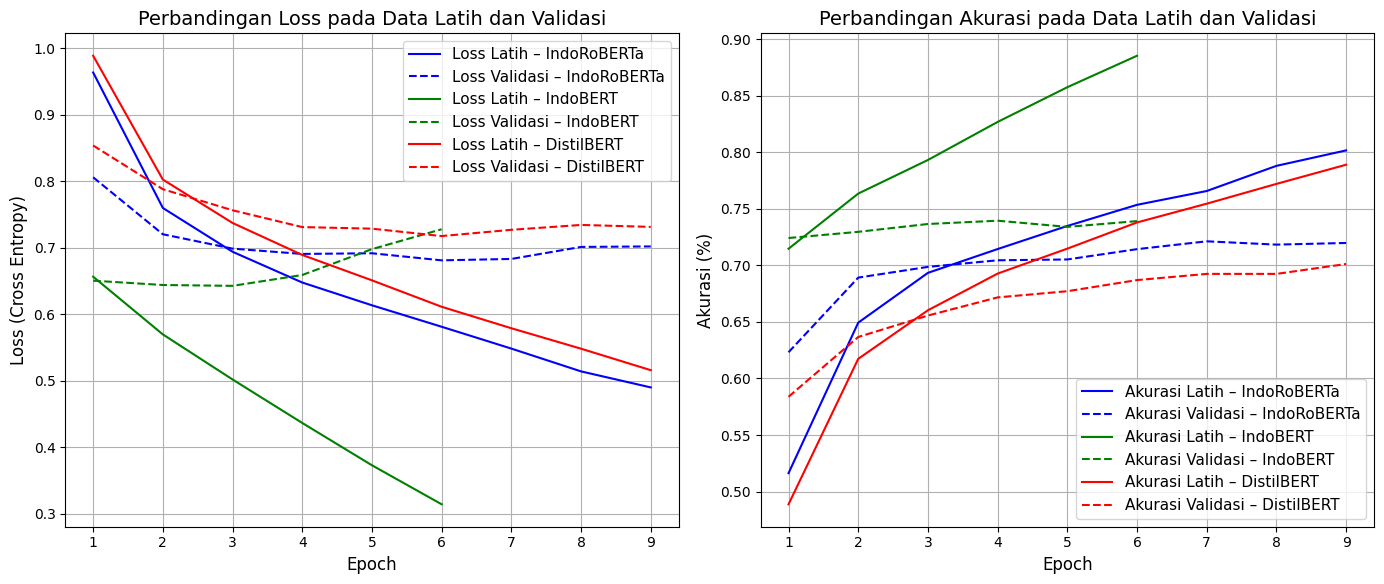

In [ ]:
import matplotlib.pyplot as plt

# Atur gaya visual dan ukuran font agar sesuai standar jurnal
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Tentukan jumlah epoch dari panjang data
epochs1 = range(1, len(train_losses1) + 1)
epochs2 = range(1, len(train_losses2) + 1)
epochs4 = range(1, len(train_losses4) + 1)

plt.figure(figsize=(14, 6))

# === SUBPLOT 1: Grafik Loss ===
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_losses1, 'b-', label='Loss Latih – IndoRoBERTa')
plt.plot(epochs1, valid_losses1, 'b--', label='Loss Validasi – IndoRoBERTa')
plt.plot(epochs2, train_losses2, 'g-', label='Loss Latih – IndoBERT')
plt.plot(epochs2, valid_losses2, 'g--', label='Loss Validasi – IndoBERT')
plt.plot(epochs4, train_losses4, 'r-', label='Loss Latih – DistilBERT')
plt.plot(epochs4, valid_losses4, 'r--', label='Loss Validasi – DistilBERT')
plt.title('Perbandingan Loss pada Data Latih dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

# === SUBPLOT 2: Grafik Akurasi ===
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_accuracies1, 'b-', label='Akurasi Latih – IndoRoBERTa')
plt.plot(epochs1, valid_accuracies1, 'b--', label='Akurasi Validasi – IndoRoBERTa')
plt.plot(epochs2, train_accuracies2, 'g-', label='Akurasi Latih – IndoBERT')
plt.plot(epochs2, valid_accuracies2, 'g--', label='Akurasi Validasi – IndoBERT')
plt.plot(epochs4, train_accuracies4, 'r-', label='Akurasi Latih – DistilBERT')
plt.plot(epochs4, valid_accuracies4, 'r--', label='Akurasi Validasi – DistilBERT')
plt.title('Perbandingan Akurasi pada Data Latih dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True)

# Tata letak otomatis dan simpan sebagai gambar vektor
plt.tight_layout()
plt.savefig("perbandingan_model_indobert.svg", format='svg')  # Simpan dalam format .svg
plt.show()


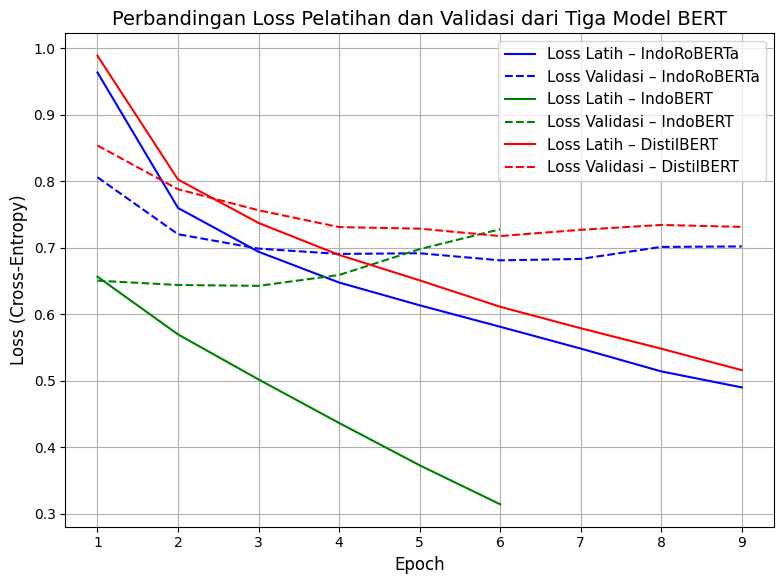

In [ ]:
import matplotlib.pyplot as plt

# Gaya visual standar untuk publikasi
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Epoch
epochs1 = range(1, len(train_losses1) + 1)
epochs2 = range(1, len(train_losses2) + 1)
epochs4 = range(1, len(train_losses4) + 1)

# === Grafik Loss ===
plt.figure(figsize=(8, 6))
plt.plot(epochs1, train_losses1, 'b-', label='Loss Latih – IndoRoBERTa')
plt.plot(epochs1, valid_losses1, 'b--', label='Loss Validasi – IndoRoBERTa')
plt.plot(epochs2, train_losses2, 'g-', label='Loss Latih – IndoBERT')
plt.plot(epochs2, valid_losses2, 'g--', label='Loss Validasi – IndoBERT')
plt.plot(epochs4, train_losses4, 'r-', label='Loss Latih – DistilBERT')
plt.plot(epochs4, valid_losses4, 'r--', label='Loss Validasi – DistilBERT')

plt.title('Perbandingan Loss Pelatihan dan Validasi dari Tiga Model BERT')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("grafik_loss_model_bert.svg", format='svg')  # Simpan dalam format vektor
plt.show()


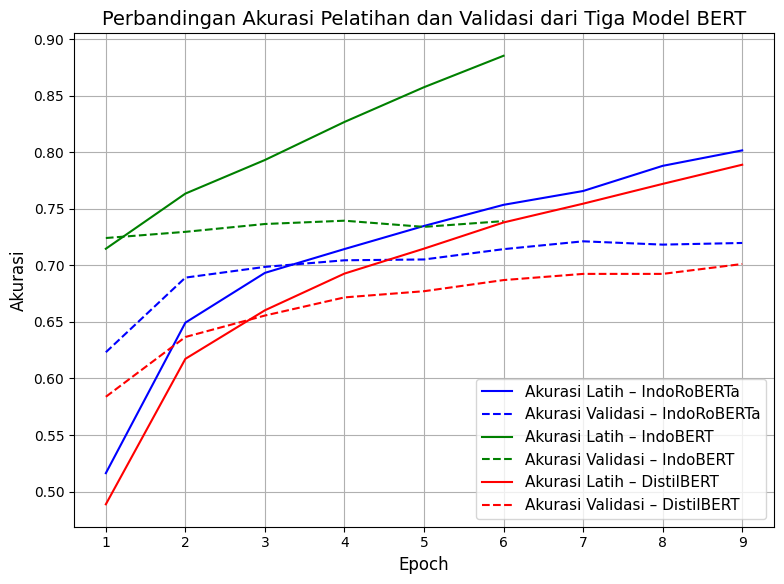

In [ ]:
# === Grafik Akurasi ===
plt.figure(figsize=(8, 6))
plt.plot(epochs1, train_accuracies1, 'b-', label='Akurasi Latih – IndoRoBERTa')
plt.plot(epochs1, valid_accuracies1, 'b--', label='Akurasi Validasi – IndoRoBERTa')
plt.plot(epochs2, train_accuracies2, 'g-', label='Akurasi Latih – IndoBERT')
plt.plot(epochs2, valid_accuracies2, 'g--', label='Akurasi Validasi – IndoBERT')
plt.plot(epochs4, train_accuracies4, 'r-', label='Akurasi Latih – DistilBERT')
plt.plot(epochs4, valid_accuracies4, 'r--', label='Akurasi Validasi – DistilBERT')

plt.title('Perbandingan Akurasi Pelatihan dan Validasi dari Tiga Model BERT')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("grafik_akurasi_model_bert.svg", format='svg')
plt.show()


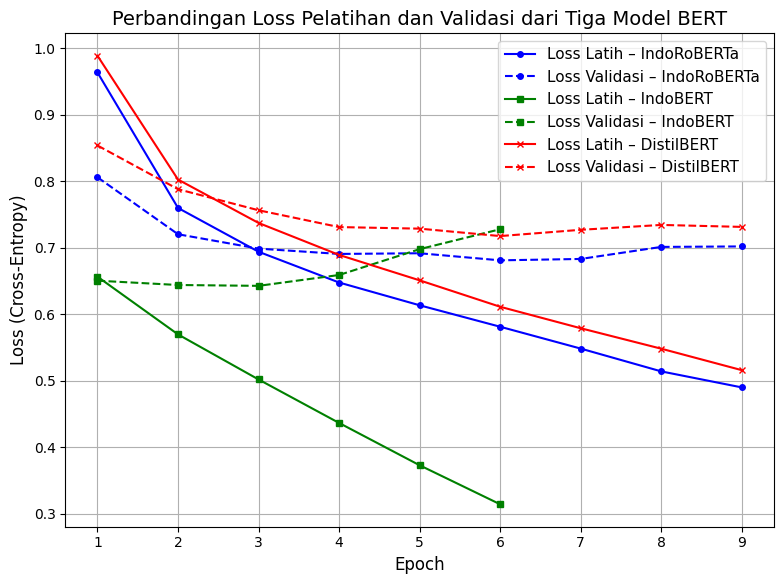

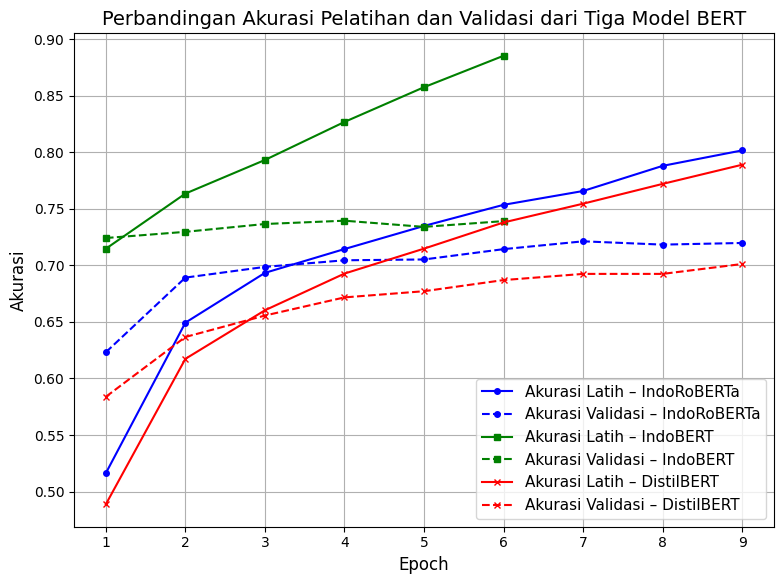

In [ ]:
import matplotlib.pyplot as plt

# Atur gaya visual standar untuk publikasi
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Tentukan epoch berdasarkan panjang data
epochs1 = range(1, len(train_losses1) + 1)
epochs2 = range(1, len(train_losses2) + 1)
epochs4 = range(1, len(train_losses4) + 1)

# === Grafik Loss ===
plt.figure(figsize=(8, 6))
plt.plot(epochs1, train_losses1, 'b-o', markersize=4, label='Loss Latih – IndoRoBERTa')
plt.plot(epochs1, valid_losses1, 'b--o', markersize=4, label='Loss Validasi – IndoRoBERTa')
plt.plot(epochs2, train_losses2, 'g-s', markersize=4, label='Loss Latih – IndoBERT')
plt.plot(epochs2, valid_losses2, 'g--s', markersize=4, label='Loss Validasi – IndoBERT')
plt.plot(epochs4, train_losses4, 'r-x', markersize=4, label='Loss Latih – DistilBERT')
plt.plot(epochs4, valid_losses4, 'r--x', markersize=4, label='Loss Validasi – DistilBERT')

plt.title('Perbandingan Loss Pelatihan dan Validasi dari Tiga Model BERT')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("grafik_loss_model_bert.svg", format='svg')
plt.show()

# === Grafik Akurasi ===
plt.figure(figsize=(8, 6))
plt.plot(epochs1, train_accuracies1, 'b-o', markersize=4, label='Akurasi Latih – IndoRoBERTa')
plt.plot(epochs1, valid_accuracies1, 'b--o', markersize=4, label='Akurasi Validasi – IndoRoBERTa')
plt.plot(epochs2, train_accuracies2, 'g-s', markersize=4, label='Akurasi Latih – IndoBERT')
plt.plot(epochs2, valid_accuracies2, 'g--s', markersize=4, label='Akurasi Validasi – IndoBERT')
plt.plot(epochs4, train_accuracies4, 'r-x', markersize=4, label='Akurasi Latih – DistilBERT')
plt.plot(epochs4, valid_accuracies4, 'r--x', markersize=4, label='Akurasi Validasi – DistilBERT')

plt.title('Perbandingan Akurasi Pelatihan dan Validasi dari Tiga Model BERT')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("grafik_akurasi_model_bert.svg", format='svg')
plt.show()


# IndoBERT Lite

In [ ]:
tokenizer7 = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config7 = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config7.num_labels = DocumentSentimentDataset.NUM_LABELS
model7 = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config7)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model7

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
count_param(model7)

124443651

In [ ]:
indobertLite_param_count = count_param(model7, trainable=True)

In [ ]:
train_dataset7 = DocumentSentimentDataset(train_dataset_path, tokenizer7, lowercase=True)
valid_dataset7 = DocumentSentimentDataset(valid_dataset_path, tokenizer7, lowercase=True)
test_dataset7 = DocumentSentimentDataset(test_dataset_path, tokenizer7, lowercase=True)

train_loader7 = DocumentSentimentDataLoader(dataset=train_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader7 = DocumentSentimentDataLoader(dataset=valid_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader7 = DocumentSentimentDataLoader(dataset=test_dataset7, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'bacot'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bacot | Label : neutral (34.577%)


In [ ]:
text = 'taktik pelatih sty bagus'
subwords = tokenizer7.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model7.device)

logits = model7(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: taktik pelatih sty bagus | Label : negative (39.811%)


In [ ]:
optimizer = optim.Adam(model7.parameters(), lr=3e-6)
model = model7.cuda()

In [ ]:
# Simpan metrik untuk visualisasi
train_losses3 = []
train_accuracies3 = []

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

# Training loop dengan pencatatan metrik
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader3, leave=True, total=len(train_loader3))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    train_losses3.append(total_train_loss / len(train_loader3))
    train_accuracies3.append(train_metrics['ACC'])

# Catat waktu dan penggunaan memori
end_time = time.time()
indobertLite_train_time = end_time - start_time
indobertLite_peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # convert to MB

print(f"indobertLite - Waktu training: {indobertLite_train_time:.2f} detik, Peak memory: {indobertLite_peak_memory:.2f} MB")

100%|██████████| 429/429 [01:20<00:00,  5.33it/s]


indobertLite - Waktu training: 407.02 detik, Peak memory: 8425.87 MB


In [ ]:
!nvidia-smi

Mon May 12 06:28:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             42W /   70W |    9208MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

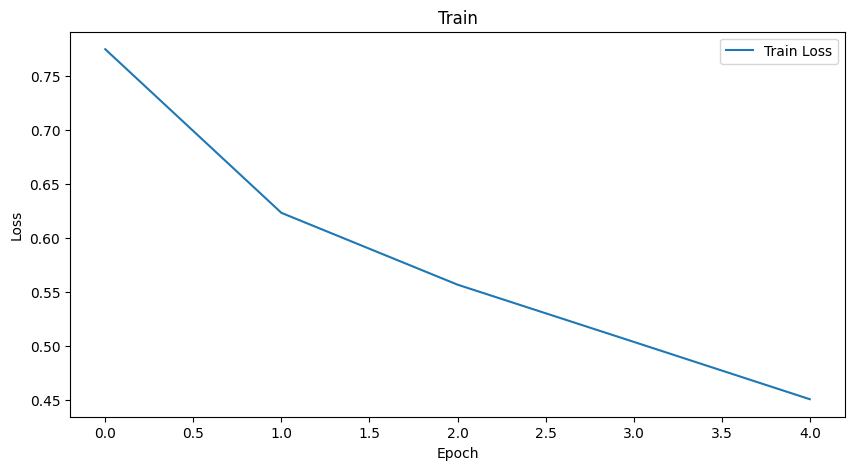

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses3, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train')
plt.show()

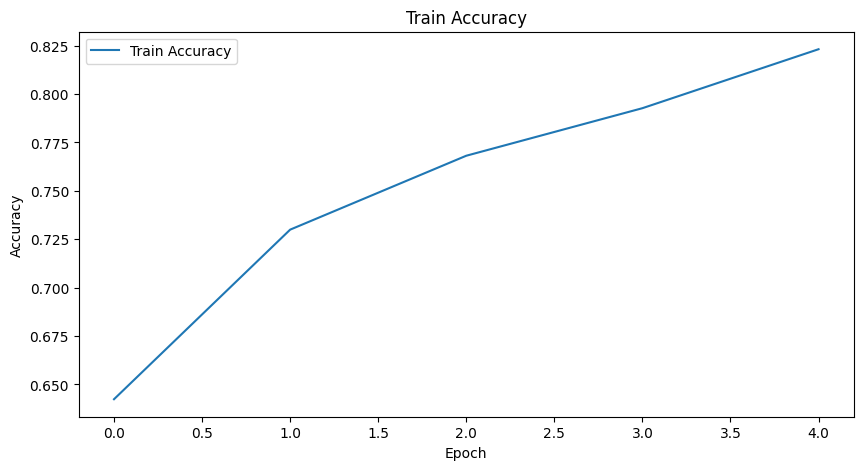

In [ ]:
# Plot akurasi
plt.figure(figsize=(10,5))
plt.plot(train_accuracies3, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy')
plt.show()

In [ ]:
# Simpan hasil prediksi ke CSV
all_texts = []

# Ulangi evaluasi untuk menyimpan teks, label, dan prediksi
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []
all_texts = []

test_pbar = tqdm(test_loader3, leave=True, total=len(test_loader3))  # atau test_loader2 untuk BERT
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    list_hyp += batch_hyp
    list_label += batch_label
    batch_texts = batch_data[-1]  # bagian terakhir adalah teks asli
    all_texts += batch_texts

# Simpan ke dalam DataFrame dan CSV
df_result = pd.DataFrame({
    'text': all_texts,
    'true_label': list_label,
    'predicted_label': list_hyp
})

df_result.to_csv('hasil_prediksi_model3.csv', index=False)  # Ganti ke model2 jika ingin simpan untuk BERT

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')

100%|██████████| 108/108 [00:06<00:00, 17.21it/s]


Test Metrics: ACC:0.73 F1:0.73 REC:0.73 PRE:0.73


In [ ]:
# Evaluate the model on the test set
model3.eval()
torch.set_grad_enabled(False)

total_test_loss = 0
list_hyp, list_label = [], []

test_pbar = tqdm(test_loader3, leave=True, total=len(test_loader3))
for i, batch_data in enumerate(test_pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model3, batch_data[:-1], i2w=i2w, device='cuda')

    total_test_loss += loss.item()
    list_hyp += batch_hyp
    list_label += batch_label

test_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print(f'Test Metrics: {metrics_to_string(test_metrics)}')


100%|██████████| 108/108 [00:06<00:00, 16.20it/s]


Test Metrics: ACC:0.74 F1:0.73 REC:0.73 PRE:0.73


In [ ]:
# classification report
print(classification_report(list_label, list_hyp))

              precision    recall  f1-score   support

    negative       0.64      0.74      0.69       903
     neutral       0.69      0.62      0.66      1256
    positive       0.84      0.83      0.84      1271

    accuracy                           0.73      3430
   macro avg       0.73      0.73      0.73      3430
weighted avg       0.73      0.73      0.73      3430



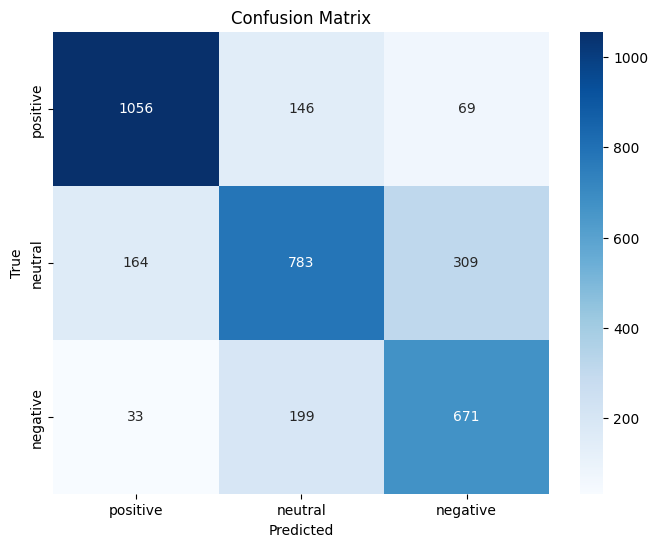

In [ ]:
labels = ['positive', 'neutral', 'negative']  # pastikan urutan konsisten

cm = confusion_matrix(list_label, list_hyp, labels=labels) # Changed this line
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
text = 'rafael mainnya jelek sekali'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: rafael mainnya jelek sekali | Label : negative (98.530%)


In [ ]:
text = 'sty stay'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty stay | Label : positive (98.720%)


In [ ]:
text = 'sty out'
subwords = tokenizer3.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model3.device)

logits = model3(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: sty out | Label : negative (93.431%)


In [ ]:
model3.save_pretrained("model_indobertLite_sentimen")
tokenizer3.save_pretrained("model_indobertLite_sentimen")


('model_indobertLite_sentimen/tokenizer_config.json',
 'model_indobertLite_sentimen/special_tokens_map.json',
 'model_indobertLite_sentimen/vocab.txt',
 'model_indobertLite_sentimen/added_tokens.json')

In [ ]:
!zip -r /content/model_indobertLite_sentimen.zip /content/model_indobertLite_sentimen
from google.colab import files
files.download("/content/model_indobertLite_sentimen.zip")


  adding: content/model_indobertLite_sentimen/ (stored 0%)
  adding: content/model_indobertLite_sentimen/tokenizer_config.json (deflated 74%)
  adding: content/model_indobertLite_sentimen/model.safetensors (deflated 7%)
  adding: content/model_indobertLite_sentimen/special_tokens_map.json (deflated 42%)
  adding: content/model_indobertLite_sentimen/config.json (deflated 55%)
  adding: content/model_indobertLite_sentimen/vocab.txt (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>